<a href="https://colab.research.google.com/github/iankim20/MAIC-AI-Challenge_hypotension-prediction/blob/main/run_testcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# %cd "/content/drive/mydrive/MAIC"

In [ ]:
%cd "/content/drive/My Drive/MAIC_data"

/content/drive/My Drive/MAIC_data


In [ ]:
!unzip ./zipfiles/test2_x.zip 
!unzip train_data.zip -d ./train_data
!unzip train_cases.zip

Archive:  ./zipfiles/test2_x.zip
  inflating: test2_x.csv             


In [ ]:
file1 = pd.read_csv("./train_data/6388.csv")
testdata= pd.read_csv("./test2_x.csv")


NameError: ignored

In [ ]:
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

print(get_size("./train_data")/1000000000, 'bytes')

27.391783989 bytes


In [ ]:
check_bp1 = testdata['abp_1']
check_bp1.isnull().sum()

18

In [ ]:
import pandas as pd
import numpy as np
import os
import csv
import pickle

# os.path.exists('./x_train_final.npz')
os.path.exists('./train_cases.csv')

True

In [ ]:
MINUTES_AHEAD = 5
SRATE = 100

# 2초 moving average
def moving_average(a, n=200):
    ret = np.nancumsum(a, dtype=np.float32)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
# # training set 로딩
# x_train = []  # arterial waveform
# y_train = []  # hypotension
# if os.path.exists('x_train.npz'):
#     print('loading train...', flush=True, end='')
#     x_train = np.load('x_train.npz')['arr_0']
#     y_train = np.load('y_train.npz')['arr_0']
#     print('done', flush=True)
# else:
#     df_train = pd.read_csv('train_cases.csv')
#     for _, row in df_train.iterrows():
#         caseid = row['caseid']
#         age = row['age']
#         sex = row['sex']
#         weight = row['weight']
#         height = row['height']

#         vals = pd.read_csv('train_data/{}.csv'.format(caseid), header=None).values.flatten()

#         # 20sec (20 00) - 5min (300 00) - 1min (60 00) = 38000 sample
#         i = 0
#         event_idx = []
#         non_event_idx = []
#         while i < len(vals) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60):
#             segx = vals[i:i + SRATE * 20]
#             segy = vals[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (1 + MINUTES_AHEAD) * 60)]

#             # 결측값 10% 이상이면
#             if np.mean(np.isnan(segx)) > 0.1 or \
#                 np.mean(np.isnan(segy)) > 0.1 or \
#                 np.max(segx) > 200 or np.min(segx) < 20 or \
#                 np.max(segy) > 200 or np.min(segy) < 20 or \
#                 np.max(segx) - np.min(segx) < 30 or \
#                 np.max(segy) - np.min(segy) < 30 or \
#                 (np.abs(np.diff(segx[~np.isnan(segx)])) > 30).any() or \
#                 (np.abs(np.diff(segy[~np.isnan(segy)])) > 30).any():
#                 i += SRATE  # 1 sec 씩 전진
#                 continue

#             # 출력 변수
#             segy = moving_average(segy, 2 * SRATE)  # 2 sec moving avg
#             event = 1 if np.nanmax(segy) < 65 else 0
#             if event:  # event
#                 event_idx.append(i)
#                 x_train.append(segx)
#                 y_train.append(event)
#             elif np.nanmin(segy) > 65:  # non event
#                 non_event_idx.append(i)
#                 x_train.append(segx)
#                 y_train.append(event)

#             i += 30 * SRATE  # 30sec

#         nsamp = len(event_idx) + len(non_event_idx)
#         if nsamp > 0:
#             print('{}: {} ({:.1f}%)'.format(caseid, nsamp, len(event_idx) * 100 / nsamp))

#     print('saving...', flush=True, end='')
#     x_train = np.array(x_train, dtype=np.float32)
#     y_train = np.array(y_train, dtype=bool)
#     np.savez_compressed('x_train.npz', x_train)
#     np.savez_compressed('y_train.npz', y_train)
#     print('done', flush=True)

In [ ]:
# 2초 moving average
def moving_average(a, n=200):
    ret = np.nancumsum(a, dtype=np.float32)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

x_train_dict = {}
y_train_dict = {}

df_train = pd.read_csv('./train_cases.csv')

x_train = []  # arterial waveform
y_train = []
percent= []


for _, row in df_train.iterrows():
    caseid = row['caseid']
    age = row['age']
    sex = row['sex']
    weight = row['weight']
    height = row['height']
    vals = pd.read_csv('train_data/{}.csv'.format(caseid), header=None).values.flatten()
    # 20sec (20 00) - 5min (300 00) - 1min (60 00) = 38000 sample
    i = 0
    event_idx = []
    non_event_idx = []
    while i < len(vals) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60):
        segx = vals[i:i + SRATE * 20]
        segy = vals[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (1 + MINUTES_AHEAD) * 60)]
        # 결측값 10% 이상이면
        if np.mean(np.isnan(segx)) > 0.1 or \
            np.mean(np.isnan(segy)) > 0.1 or \
            np.max(segx) > 200 or np.min(segx) < 20 or \
            np.max(segy) > 200 or np.min(segy) < 20 or \
            np.max(segx) - np.min(segx) < 30 or \
            np.max(segy) - np.min(segy) < 30 or \
            (np.abs(np.diff(segx[~np.isnan(segx)])) > 30).any() or \
            (np.abs(np.diff(segy[~np.isnan(segy)])) > 30).any():
            i += SRATE  # 1 sec 씩 전진
            continue
        # 출력 변수
        segy = moving_average(segy, 2 * SRATE)  # 2 sec moving avg
        event = 1 if np.nanmax(segy) < 65 else 0
        if event:  # event
            event_idx.append(i)
            x_train.append(segx)
            y_train.append(event)
            i += 1 * SRATE  # 1sec

        else:  # non event
            non_event_idx.append(i)
            x_train.append(segx)
            y_train.append(event)
            i += 30 * SRATE  # 30sec



    nsamp = len(event_idx) + len(non_event_idx)
    if nsamp > 0:
        print('{}: {} ({:.1f}%)'.format(caseid, nsamp, len(event_idx) * 100 / nsamp))
        percent
    if caseid >200 :
      break


In [ ]:
import matplotlib.pyplot as plt

check_na = pd.DataFrame.from_records(x_train)
check_na_y = pd.DataFrame(y_train)

KeyboardInterrupt: ignored

In [ ]:
### random segx with event ##
import random

with_event = []
for i in random.sample(range(1, len(check_na)), 200):
  if check_na_y.loc[i][0] == 1:
    with_event.append(check_na.iloc[[i]])


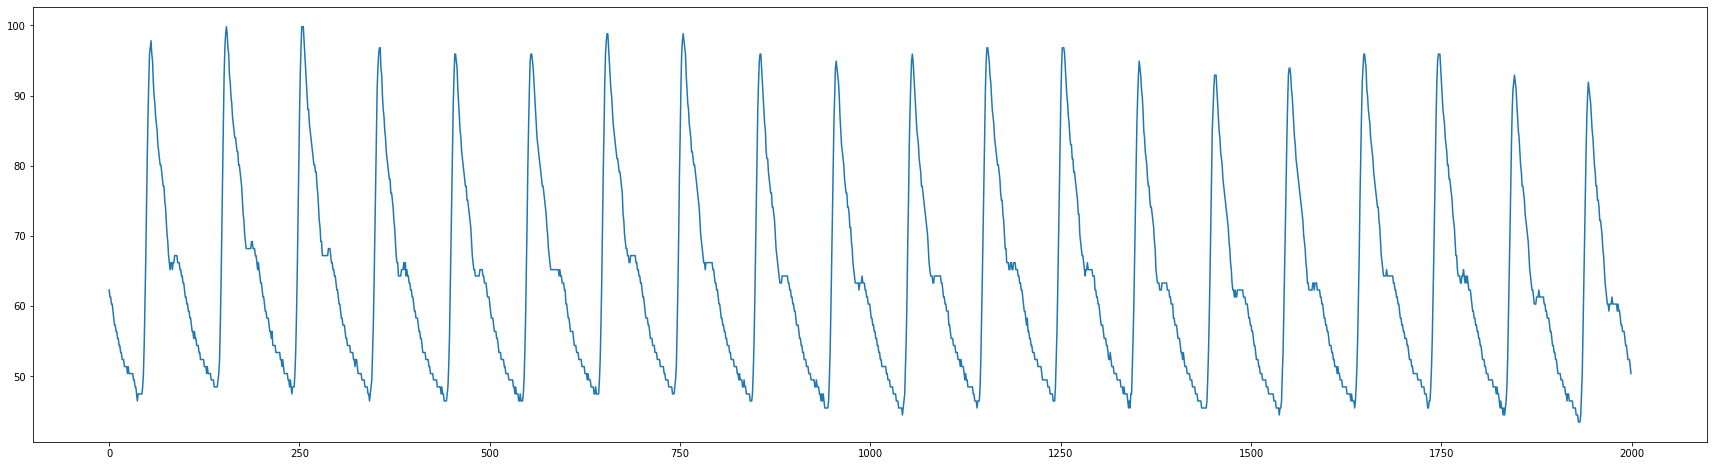

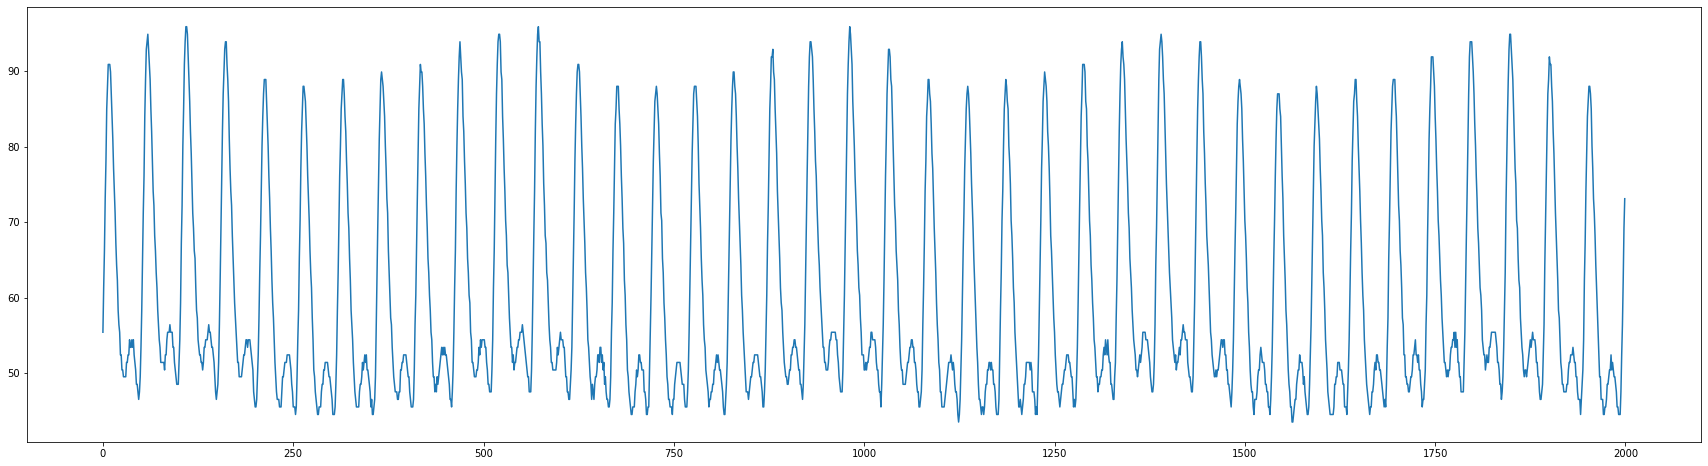

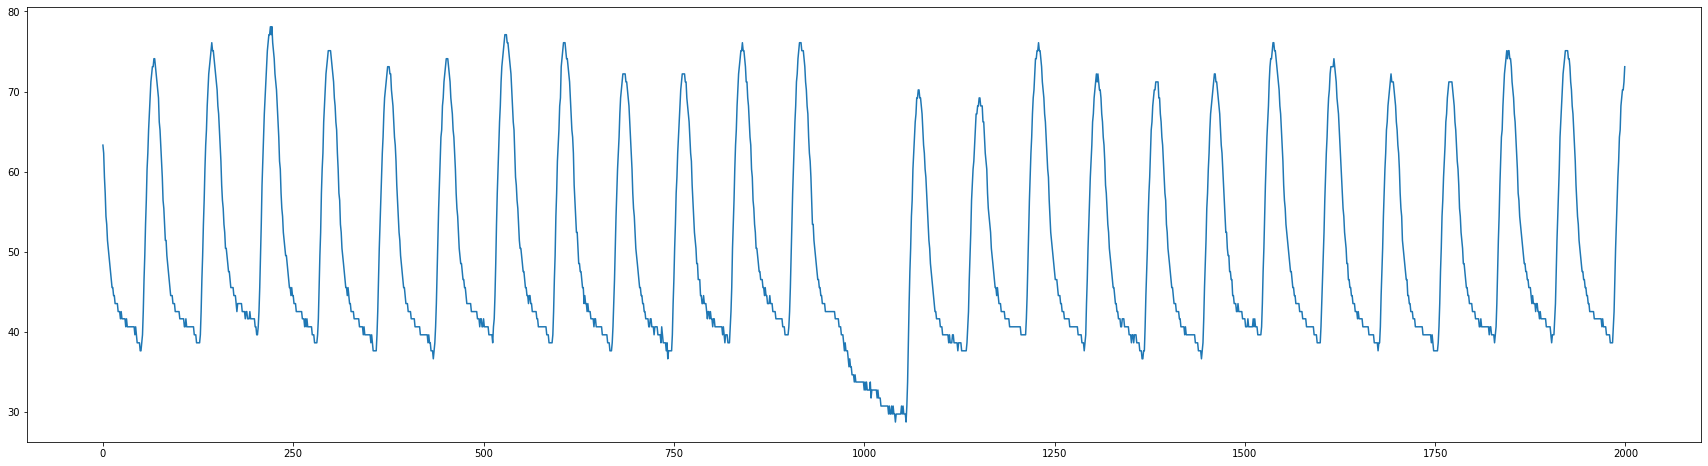

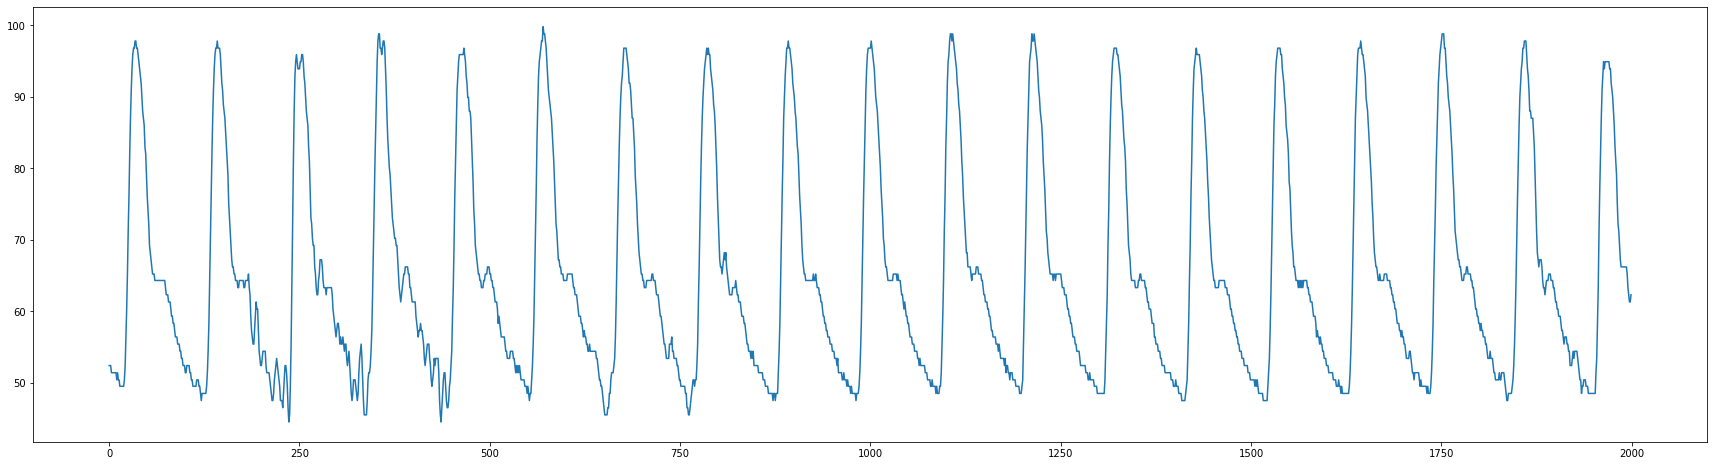

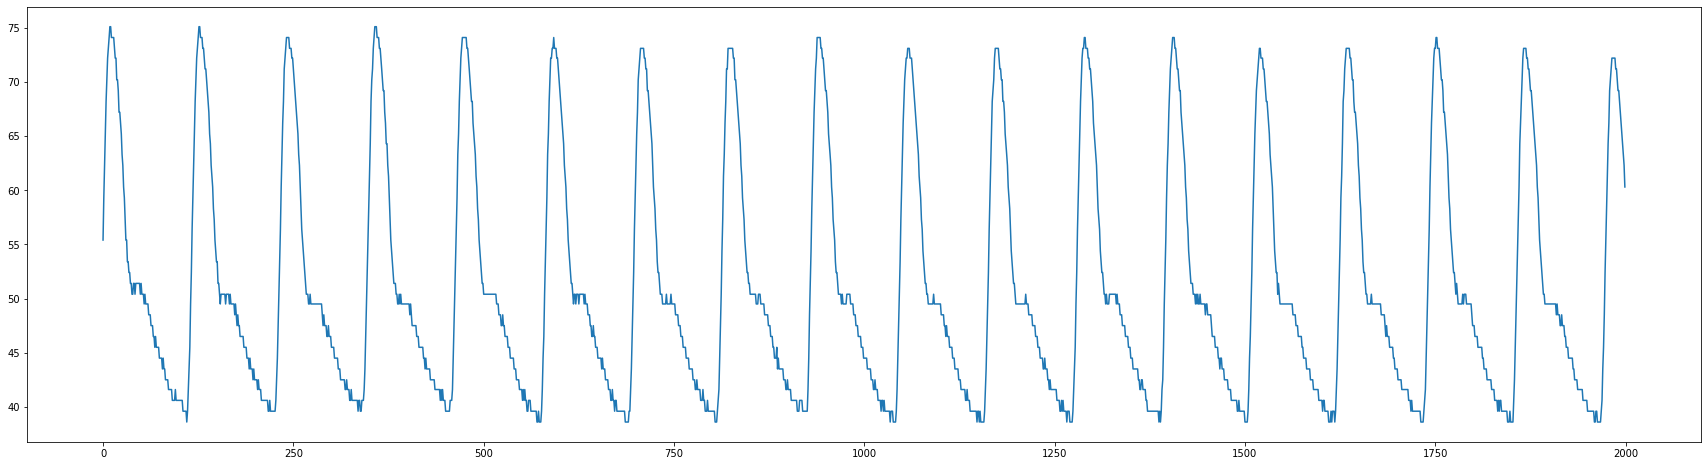

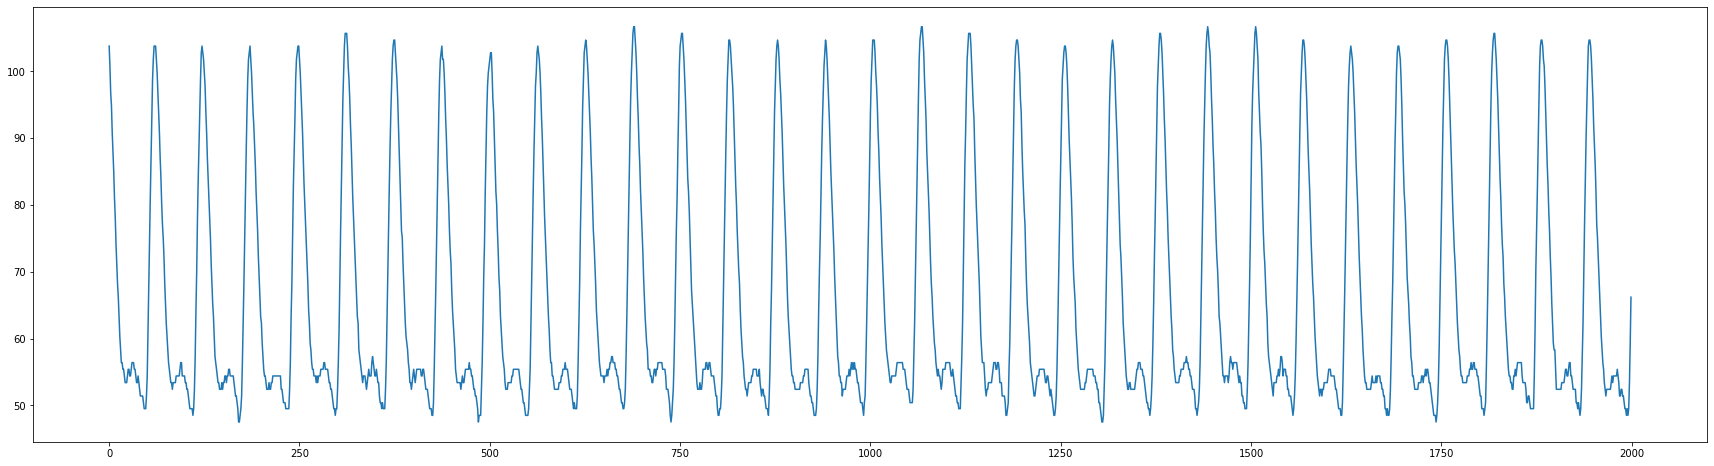

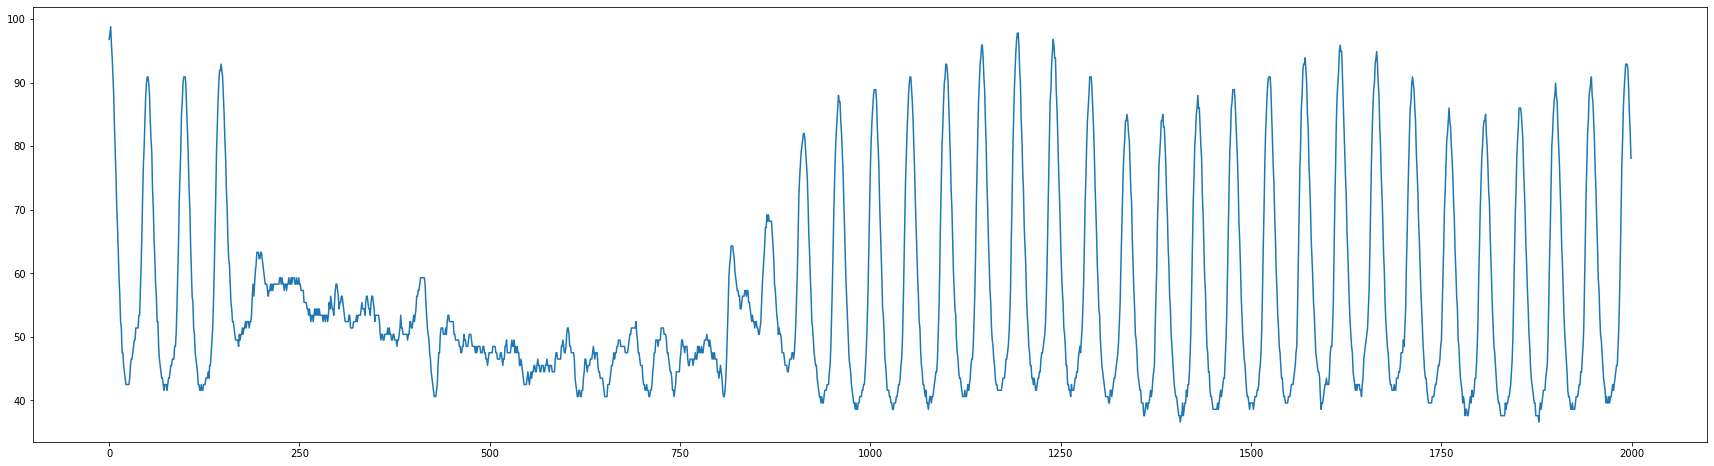

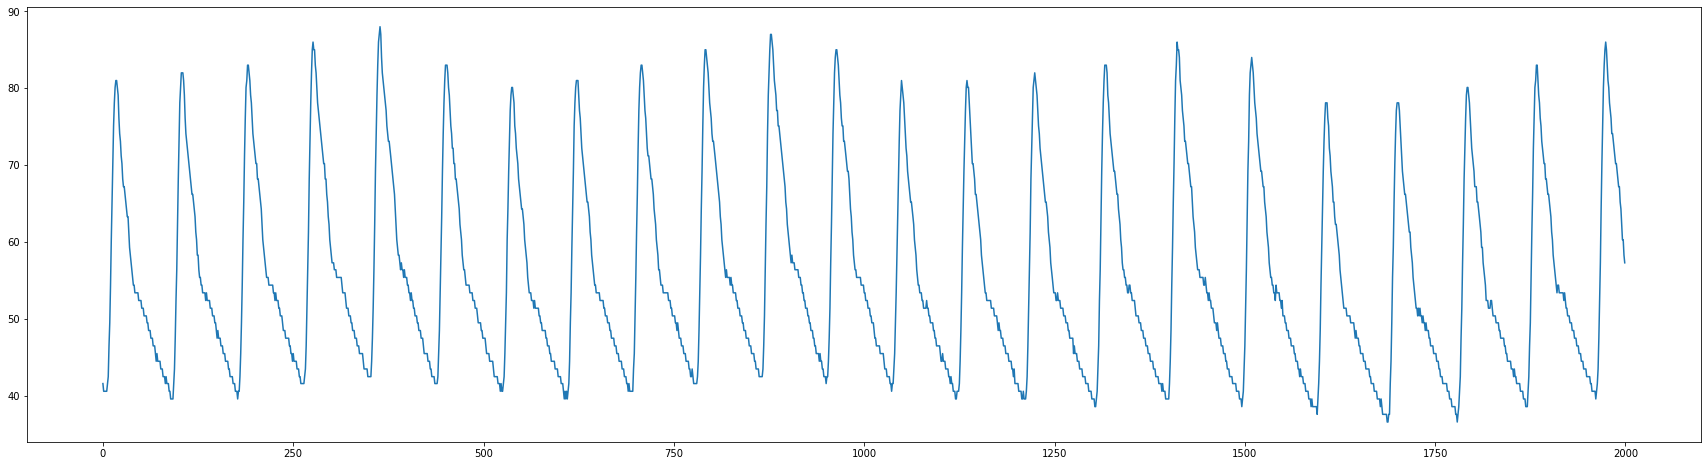

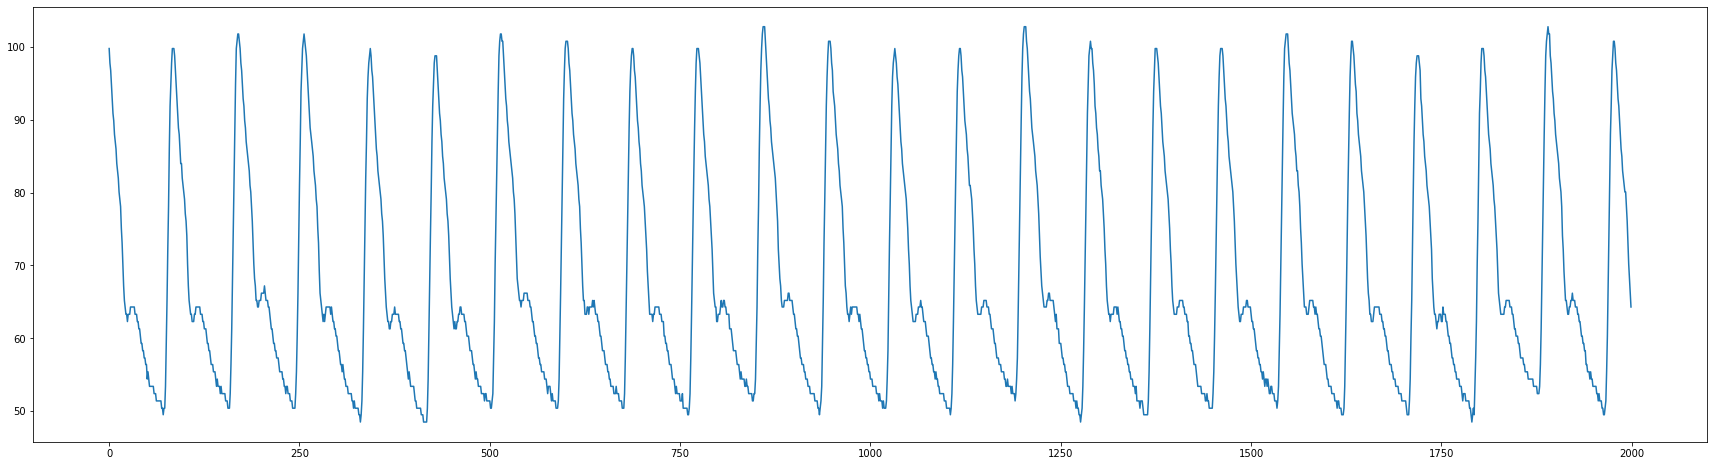

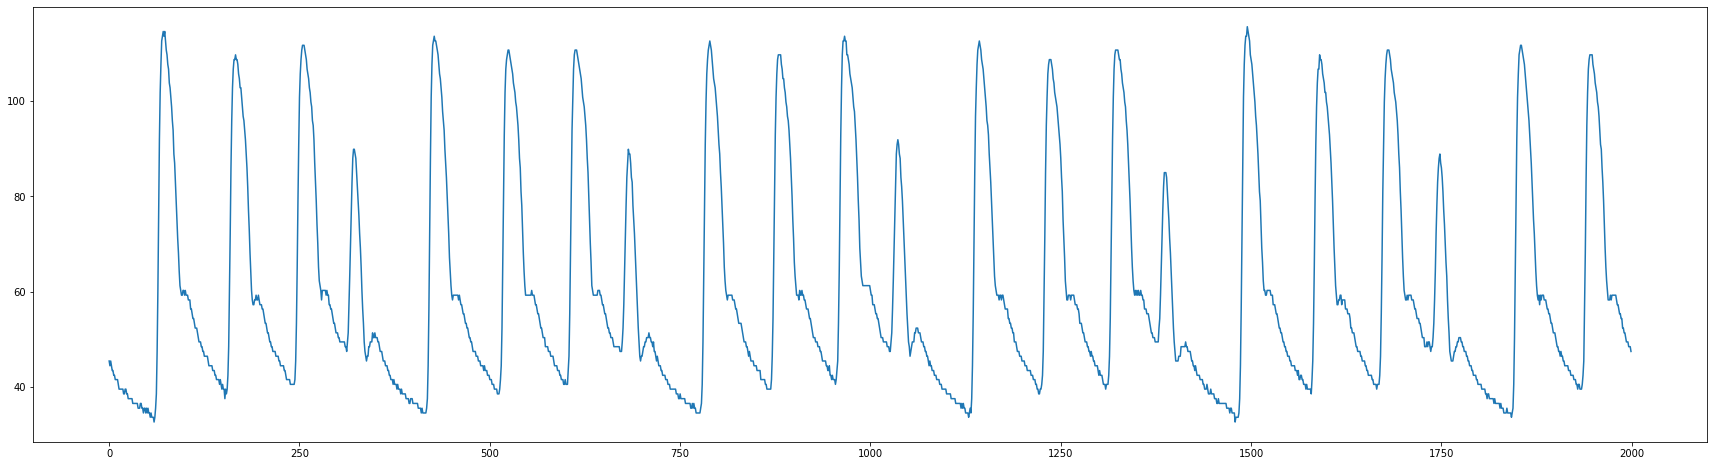

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(len(with_event)):
  row = with_event[i]
  draw = row.iloc[0]
  plt.figure(figsize=(30,8))
  plt.plot(draw)
  plt.show()




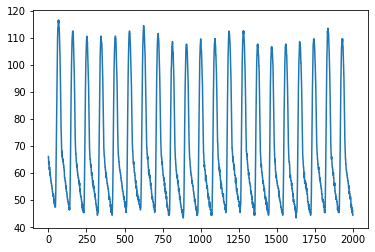

In [ ]:
draw=df_row.iloc[0]

plt.plot(draw)
plt.show()

In [ ]:
#with Nan


is_N = check_na.isnull()
row_has_NaN = is_N.any(axis=1)
rows_with_NaN = check_na[row_has_NaN]

rows_with_NaN

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


for i in range(len(rows_with_NaN)):
  plt.figure(figsize=(30,8))
  row = rows_with_NaN.iloc[i]
  print(row)
  plt.figure(figsize=(30,8))
  plt.plot(row)
  plt.show()


#transposed.plot(figsize=(30,8))




In [ ]:
check = pd.read_csv('train_data/1733.csv')

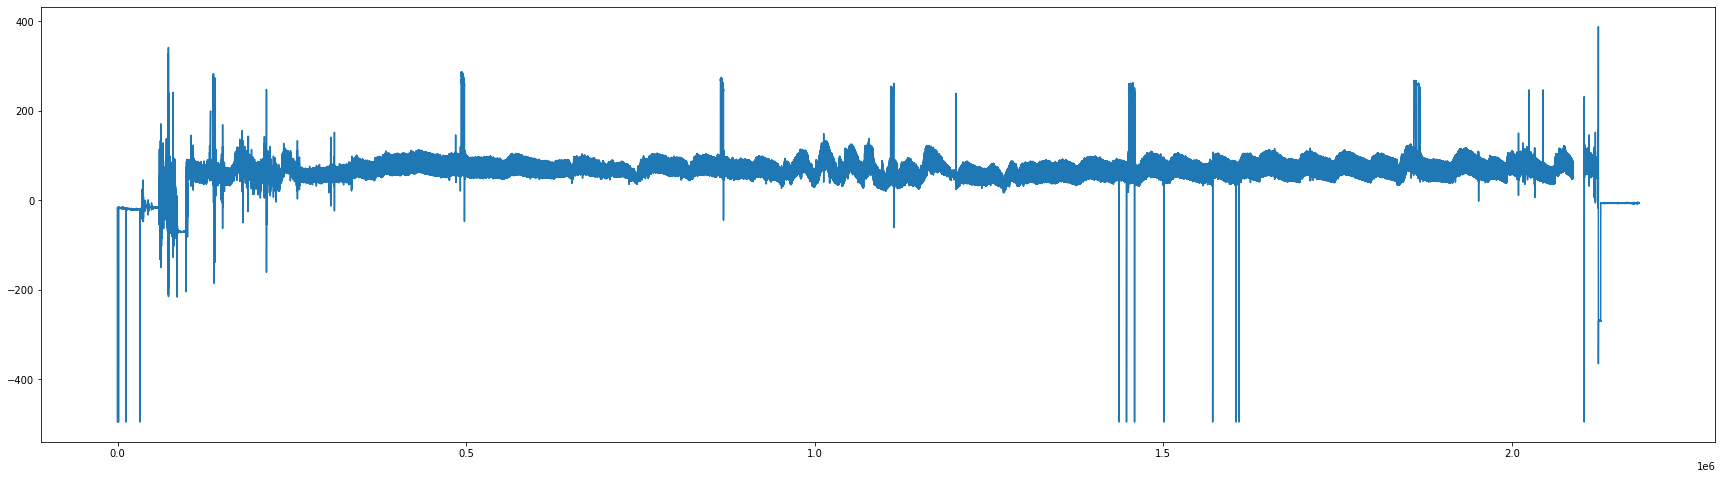

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,8))
plt.plot(check)
plt.show()

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    59.3
1996    58.3
1997    58.3
1998    58.3
1999    58.3
Name: 1413, Length: 2000, dtype: float64


<Figure size 2160x576 with 0 Axes>

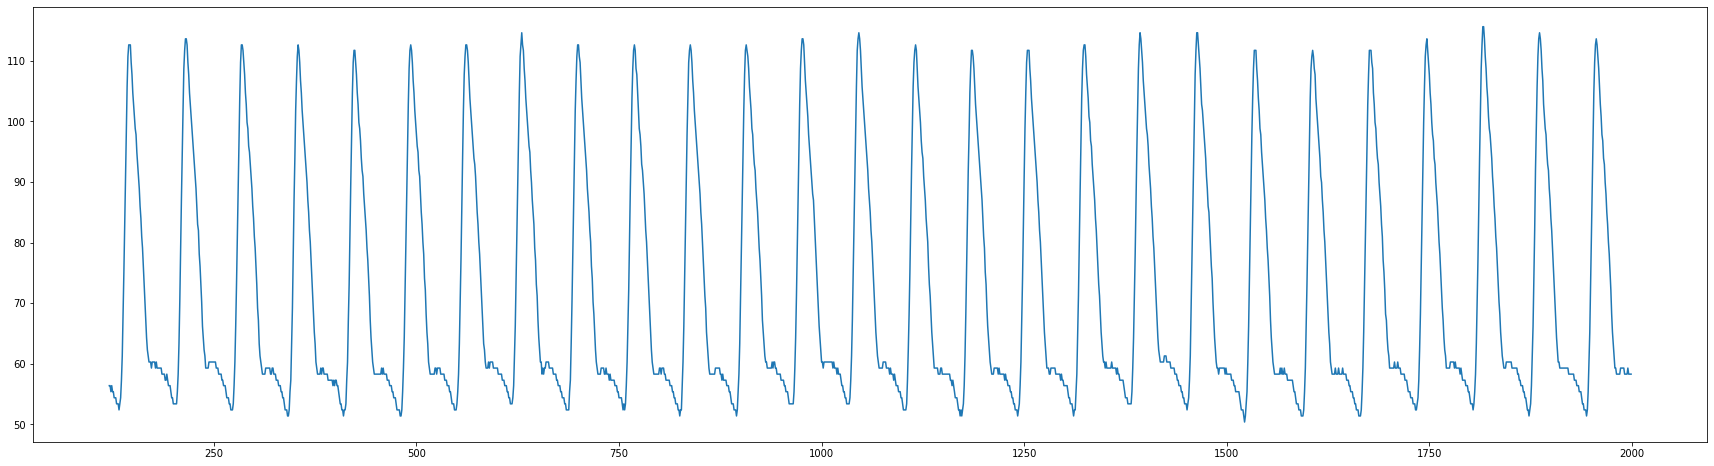

0        69.2
1        68.2
2        68.2
3        68.2
4        67.2
        ...  
1995    110.7
1996    111.7
1997    110.7
1998    109.7
1999    108.7
Name: 3552, Length: 2000, dtype: float64


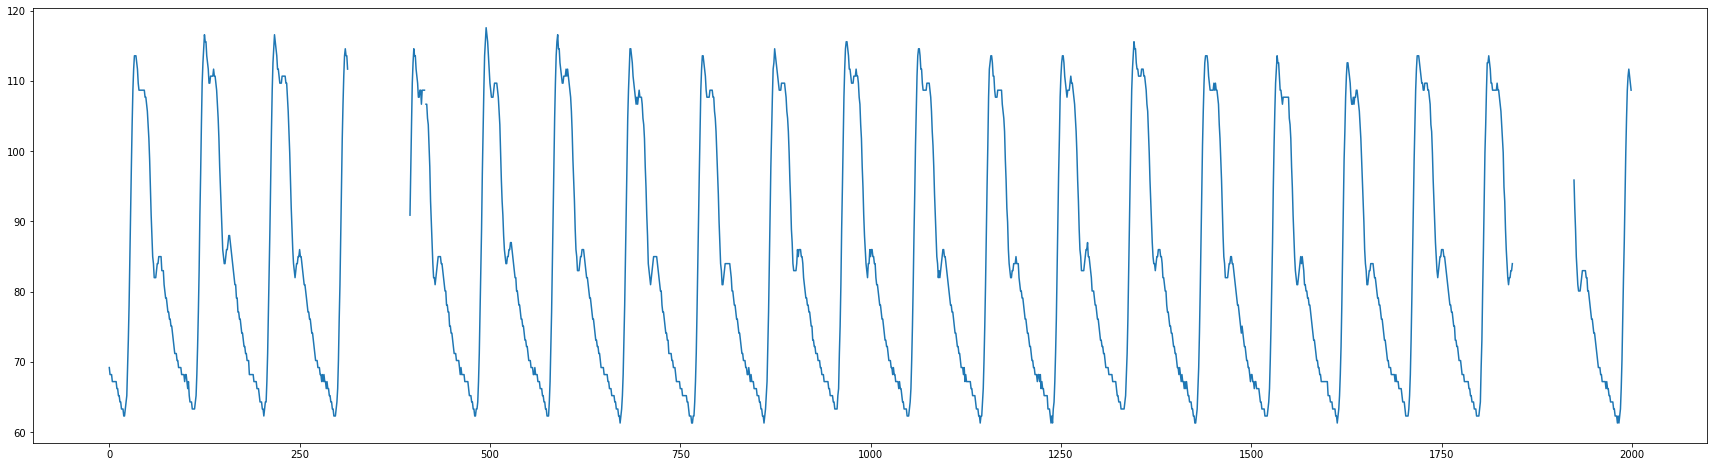

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    88.0
1996    88.0
1997    87.0
1998    86.0
1999    86.0
Name: 10726, Length: 2000, dtype: float64


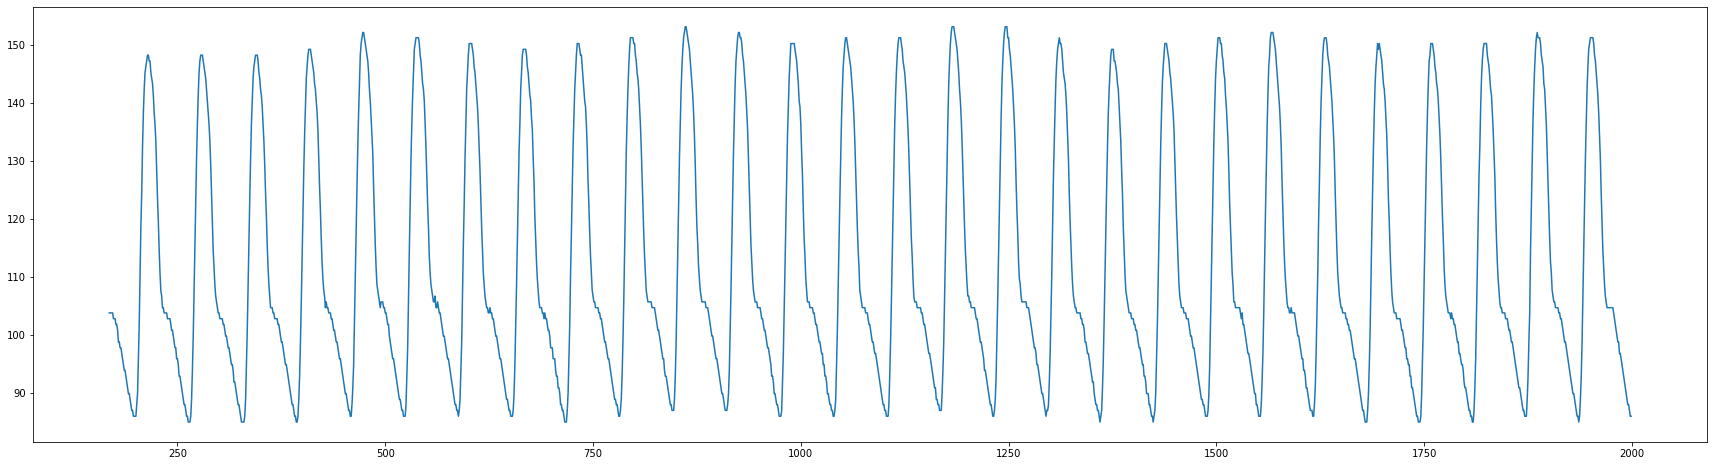

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    93.9
1996    90.9
1997    88.9
1998    86.0
1999    84.0
Name: 10970, Length: 2000, dtype: float64


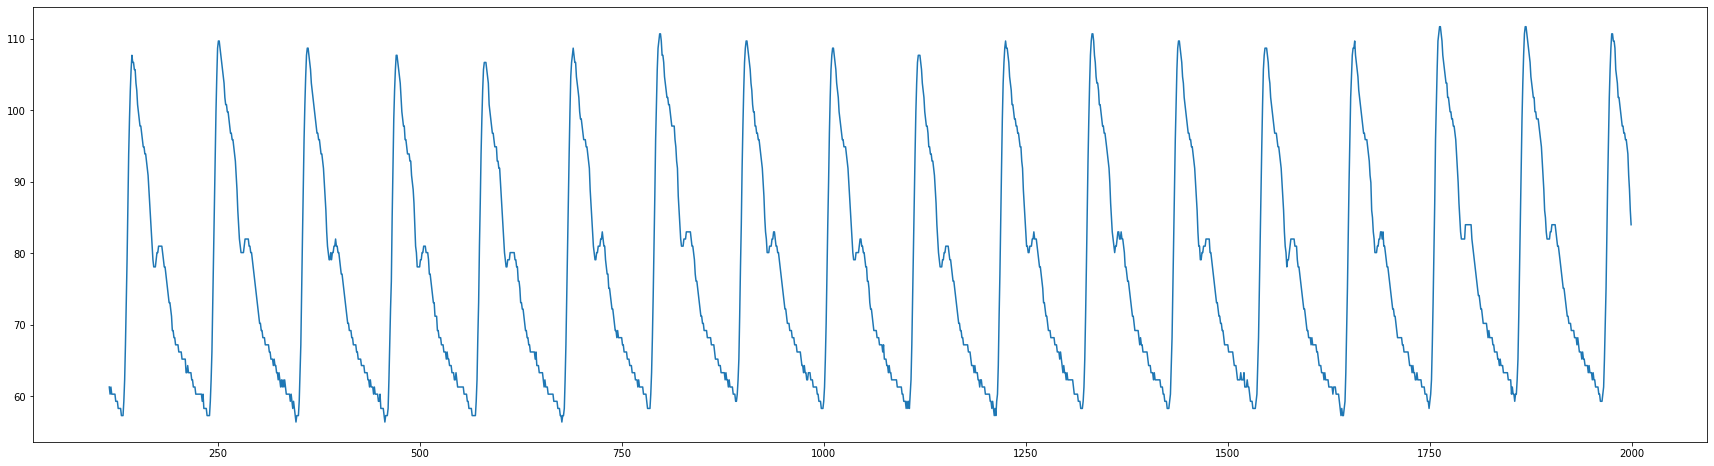

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    55.4
1996    54.4
1997    55.4
1998    54.4
1999    54.4
Name: 11834, Length: 2000, dtype: float64


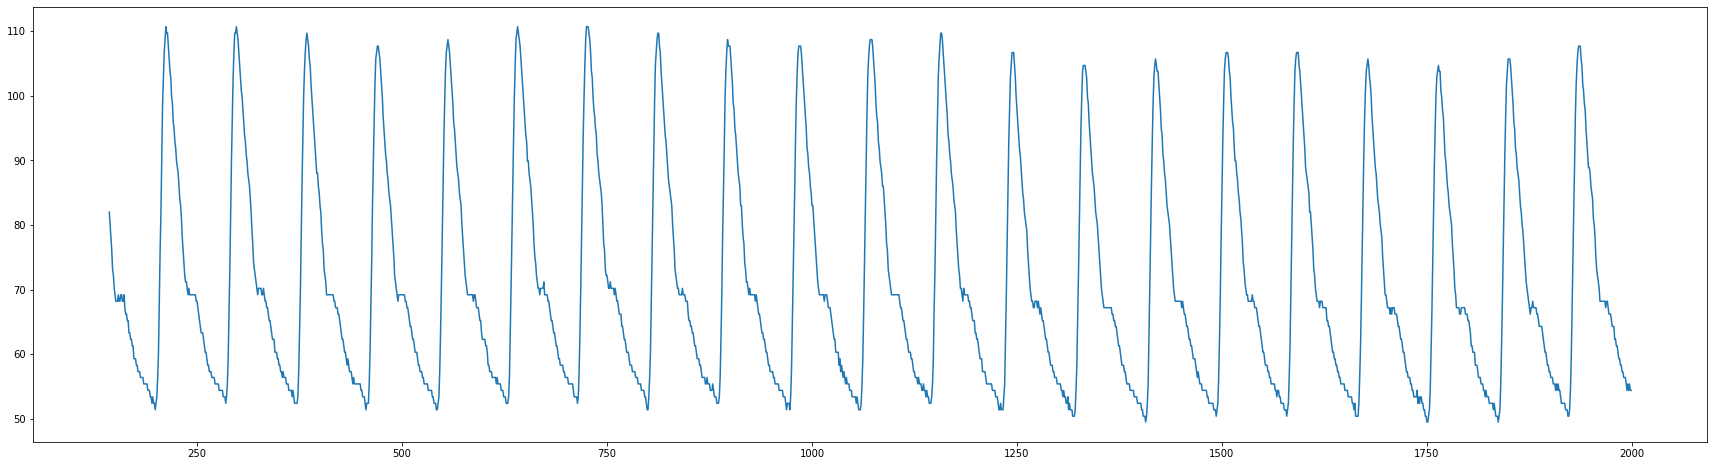

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    70.2
1996    70.2
1997    70.2
1998    72.2
1999    76.1
Name: 12992, Length: 2000, dtype: float64


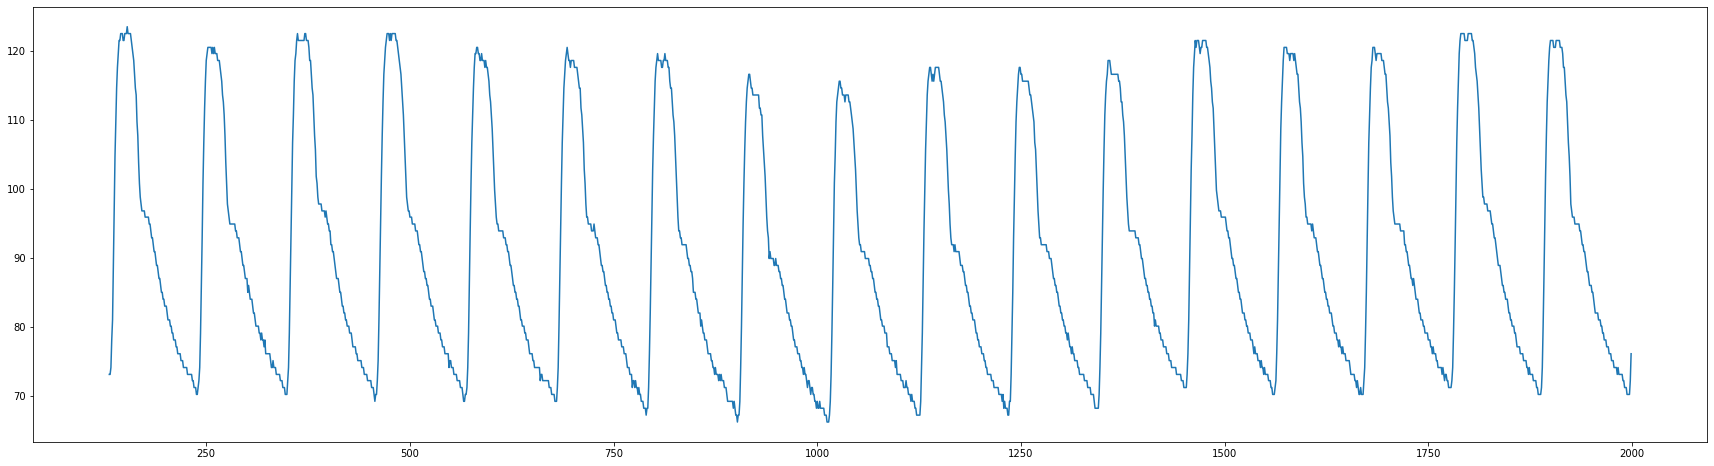

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    65.2
1996    64.3
1997    64.3
1998    63.3
1999    63.3
Name: 14195, Length: 2000, dtype: float64


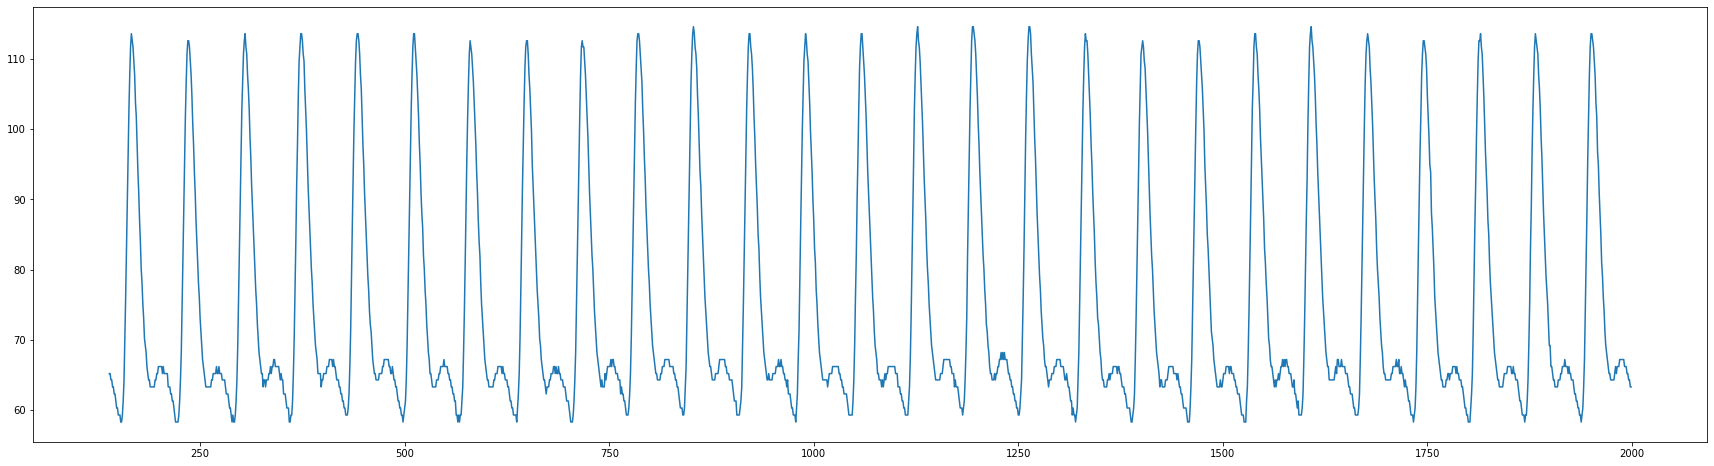

0       56.4
1       55.4
2       54.4
3       54.4
4       54.4
        ... 
1995     NaN
1996     NaN
1997     NaN
1998     NaN
1999     NaN
Name: 17745, Length: 2000, dtype: float64


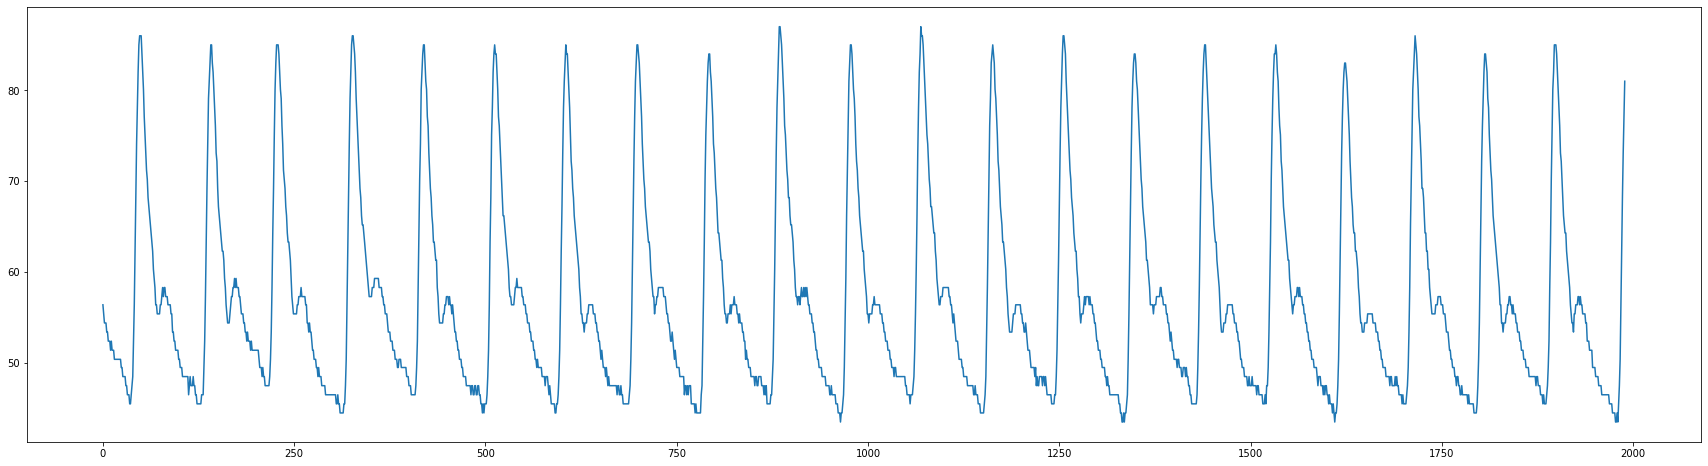

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    81.0
1996    81.0
1997    81.0
1998    80.1
1999    80.1
Name: 18999, Length: 2000, dtype: float64


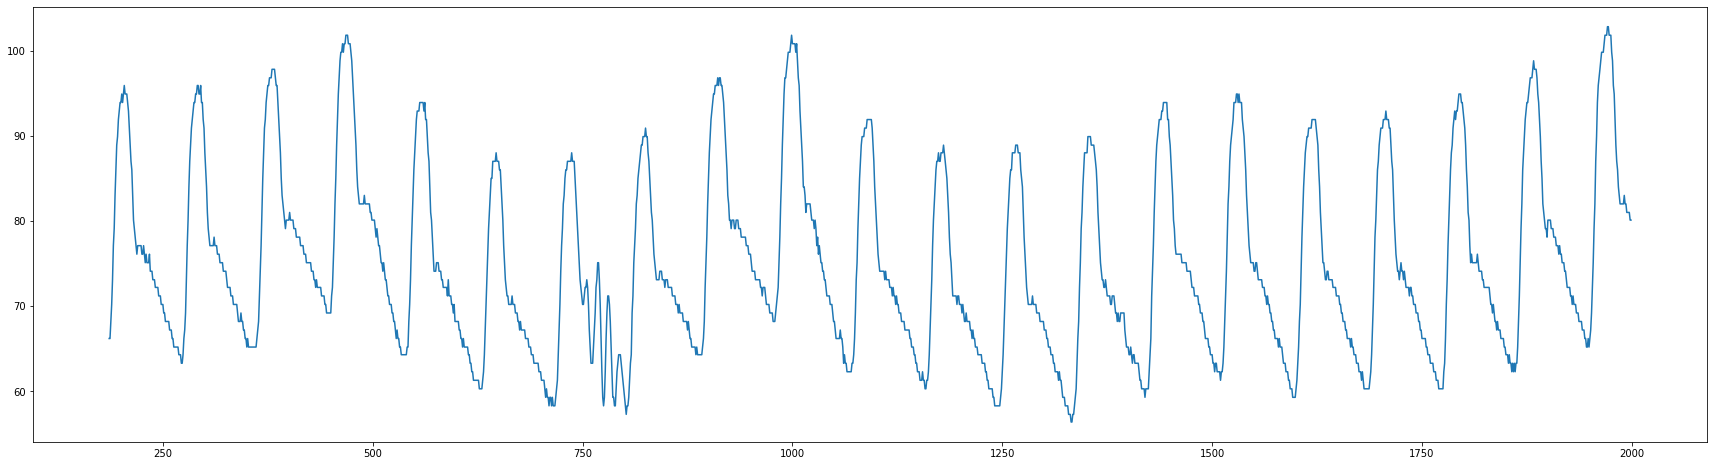

0       73.1
1       74.1
2       73.1
3       73.1
4       73.1
        ... 
1995    91.9
1996    89.9
1997    88.0
1998    85.0
1999    83.0
Name: 19002, Length: 2000, dtype: float64


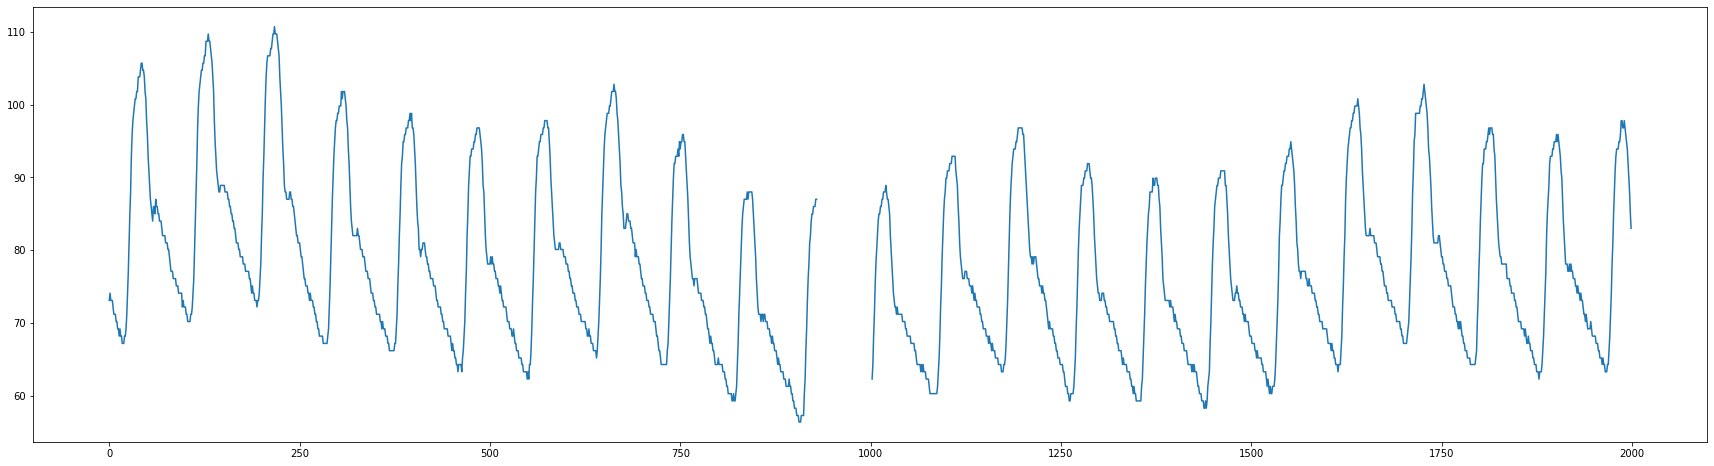

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    93.9
1996    94.9
1997    93.9
1998    93.9
1999    93.9
Name: 19014, Length: 2000, dtype: float64


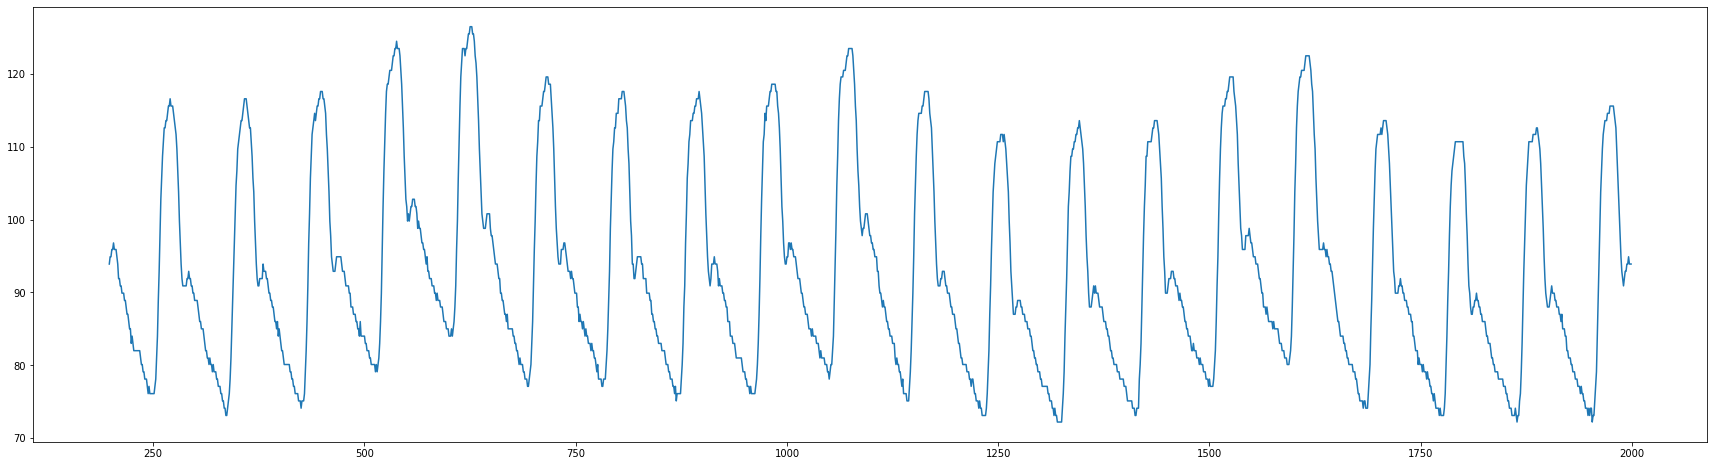

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1995   NaN
1996   NaN
1997   NaN
1998   NaN
1999   NaN
Name: 19017, Length: 2000, dtype: float64


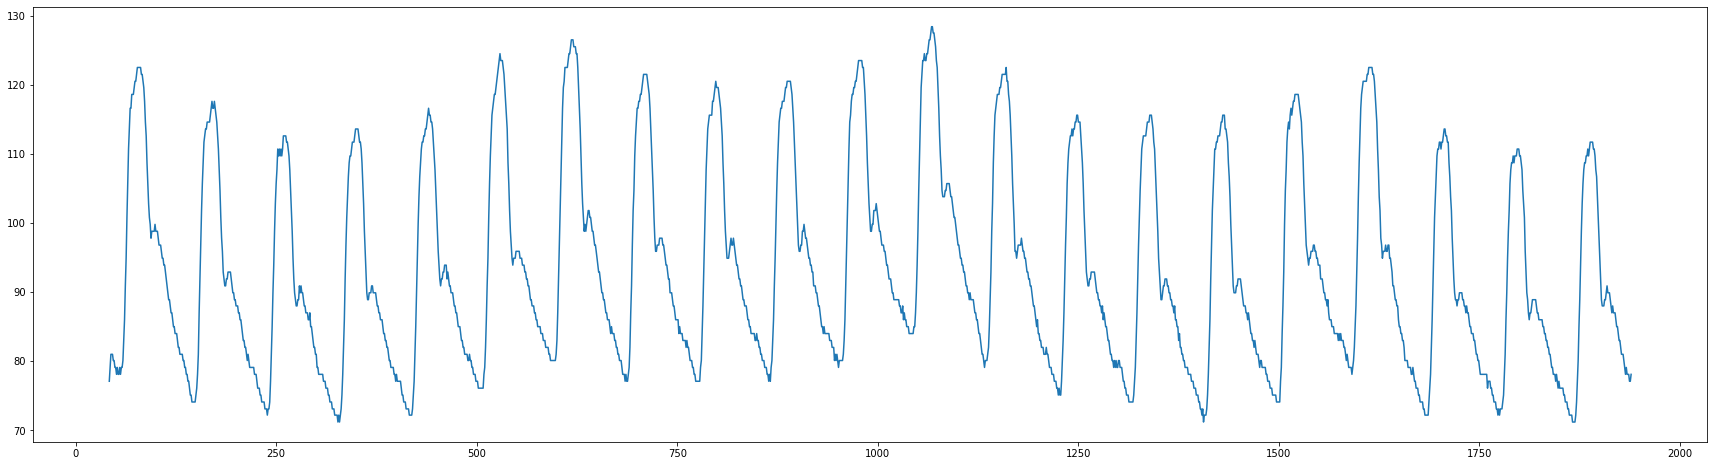

0       105.7
1       117.6
2       132.4
3       141.3
4       141.3
        ...  
1995      NaN
1996      NaN
1997      NaN
1998      NaN
1999      NaN
Name: 20841, Length: 2000, dtype: float64


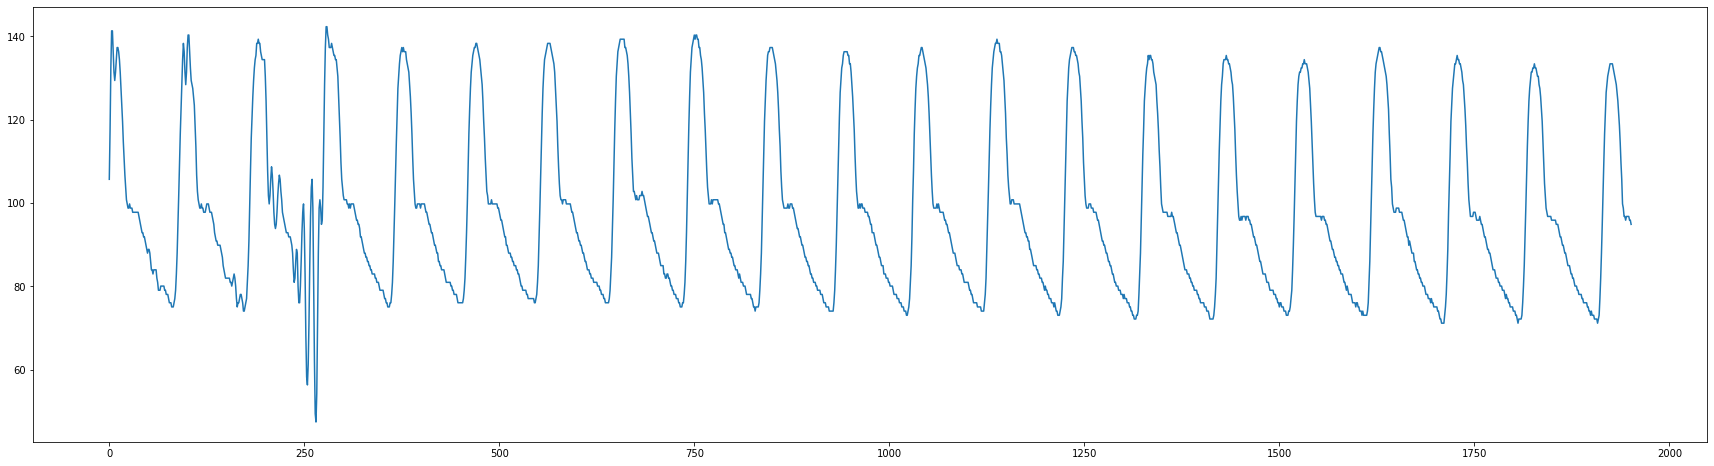

0      -16.7
1      -16.7
2      -17.7
3      -17.7
4      -16.7
        ... 
1995   -17.7
1996   -17.7
1997   -17.7
1998   -17.7
1999   -16.7
Name: 20916, Length: 2000, dtype: float64


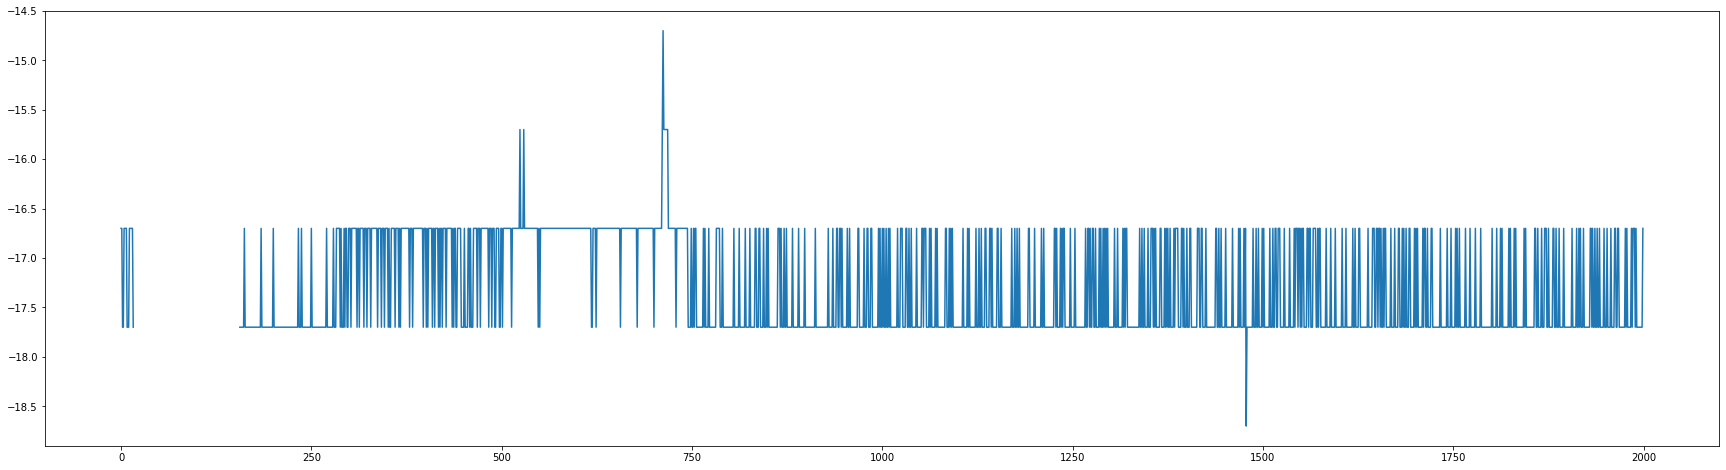

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    81.0
1996    80.1
1997    80.1
1998    80.1
1999    79.1
Name: 21654, Length: 2000, dtype: float64


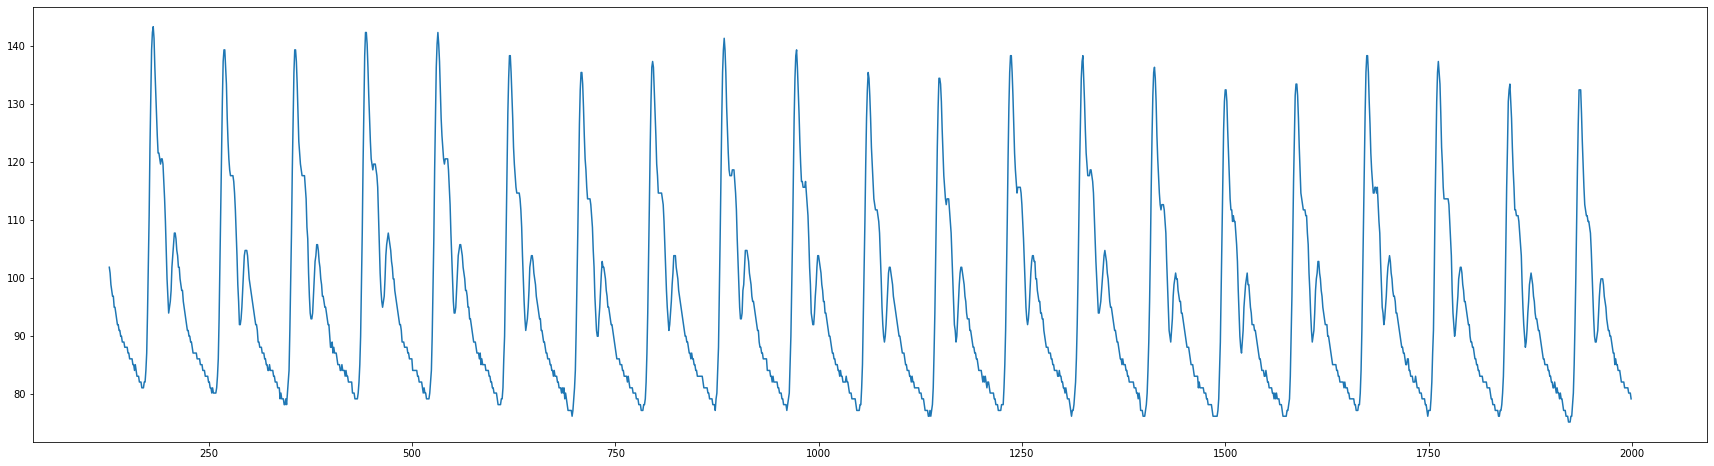

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    66.2
1996    67.2
1997    66.2
1998    66.2
1999    66.2
Name: 22821, Length: 2000, dtype: float64


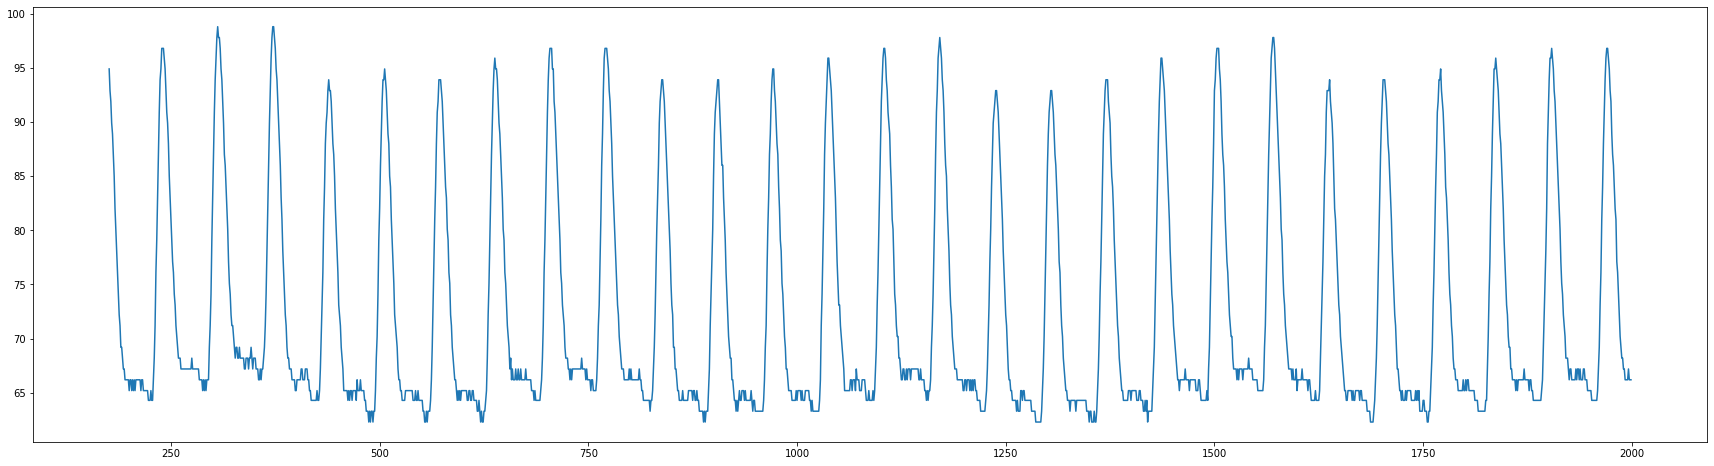

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    63.3
1996    63.3
1997    62.3
1998    63.3
1999    63.3
Name: 23319, Length: 2000, dtype: float64


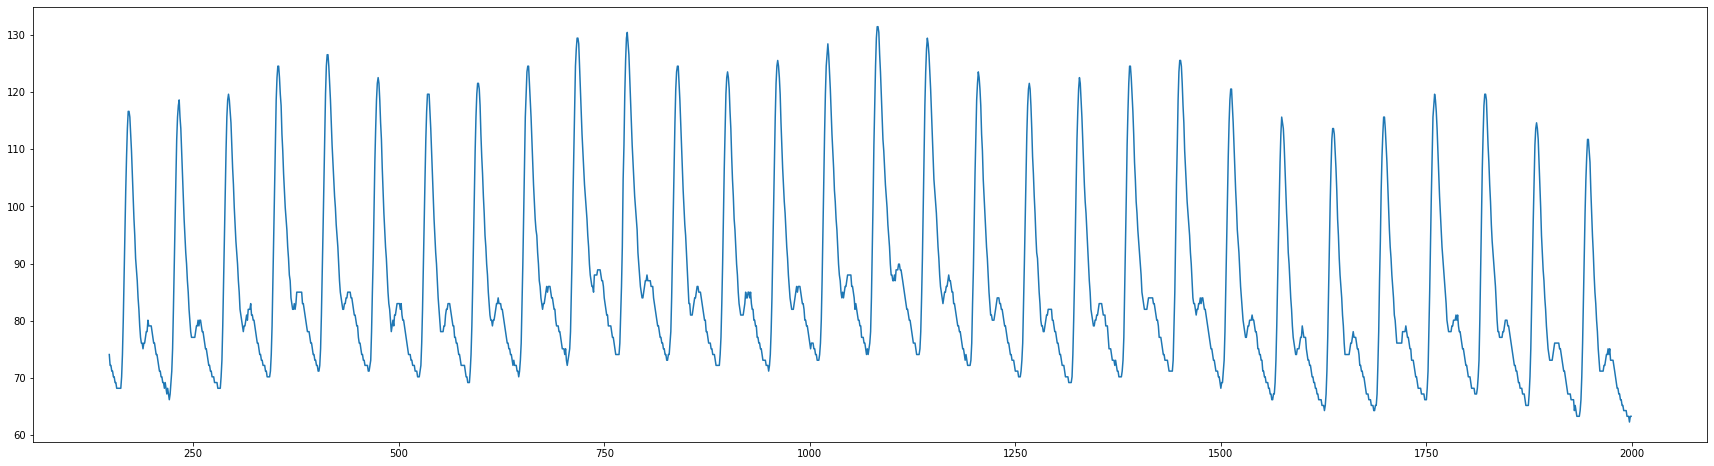

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
1995    103.8
1996    105.7
1997    106.7
1998    106.7
1999    107.7
Name: 31295, Length: 2000, dtype: float64


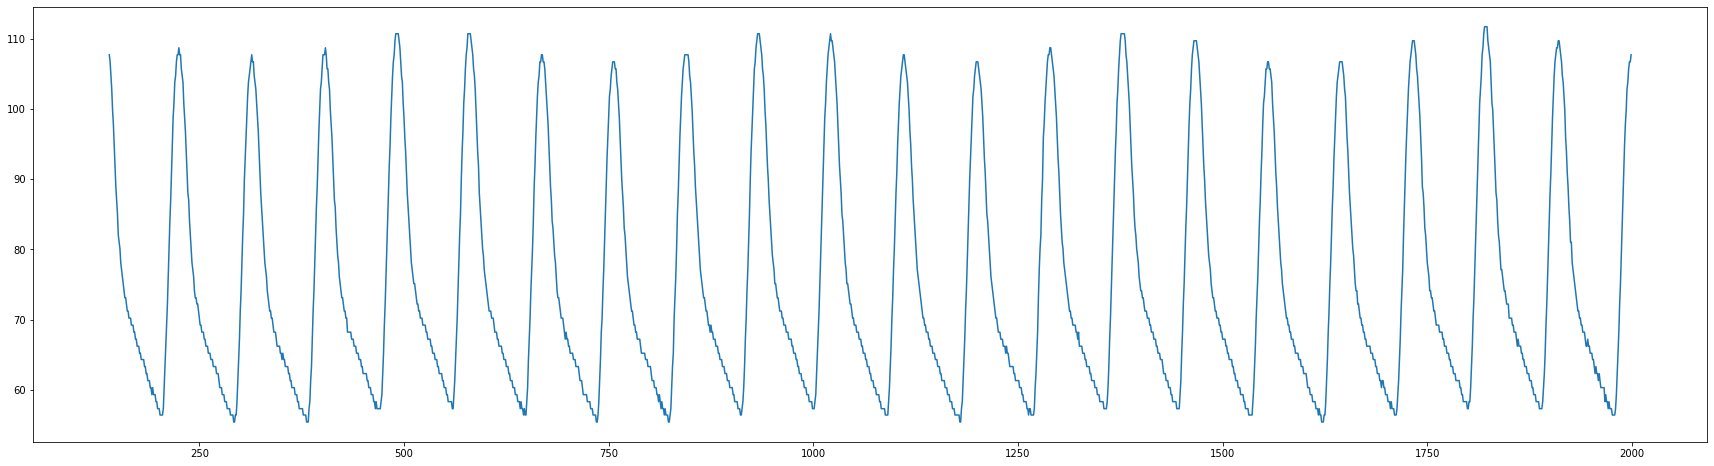

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    82.0
1996    85.0
1997    88.0
1998    90.9
1999    93.9
Name: 31354, Length: 2000, dtype: float64


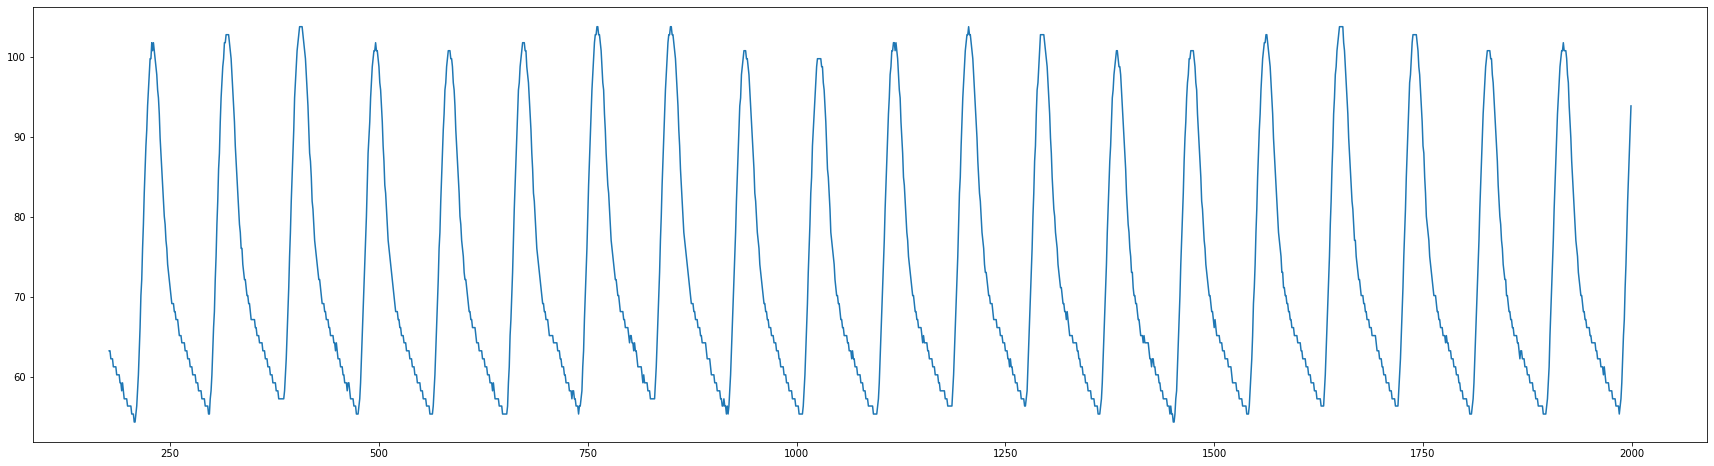

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    69.2
1996    69.2
1997    68.2
1998    68.2
1999    67.2
Name: 39186, Length: 2000, dtype: float64


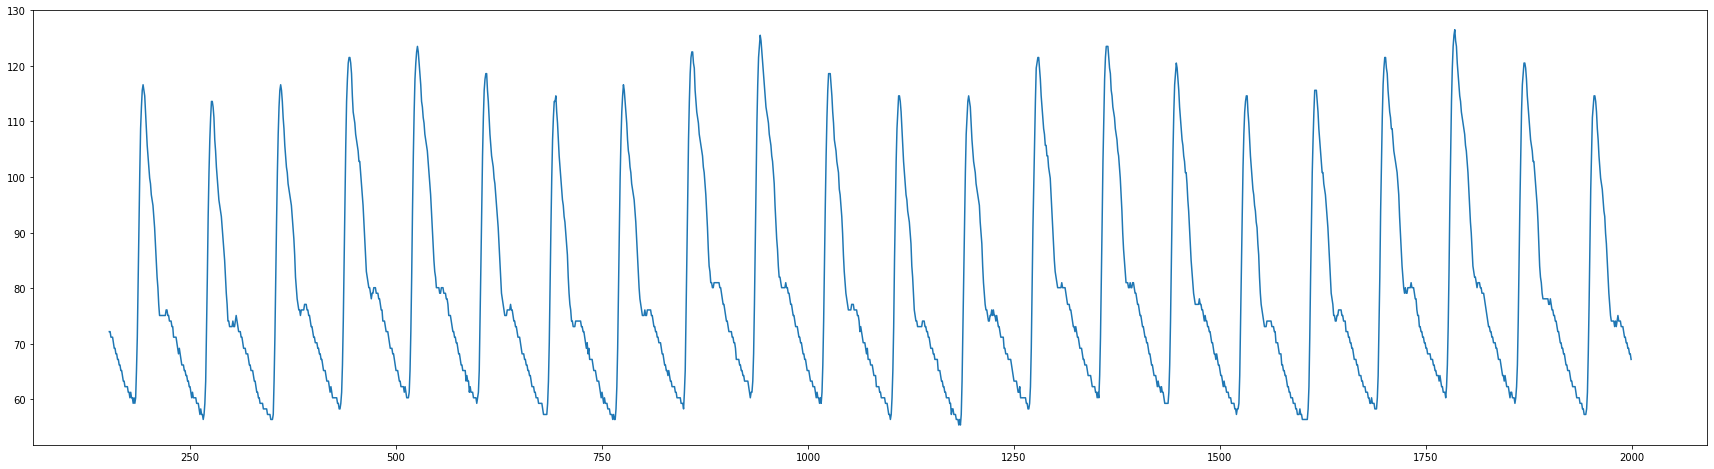

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    55.4
1996    55.4
1997    55.4
1998    54.4
1999    54.4
Name: 41060, Length: 2000, dtype: float64


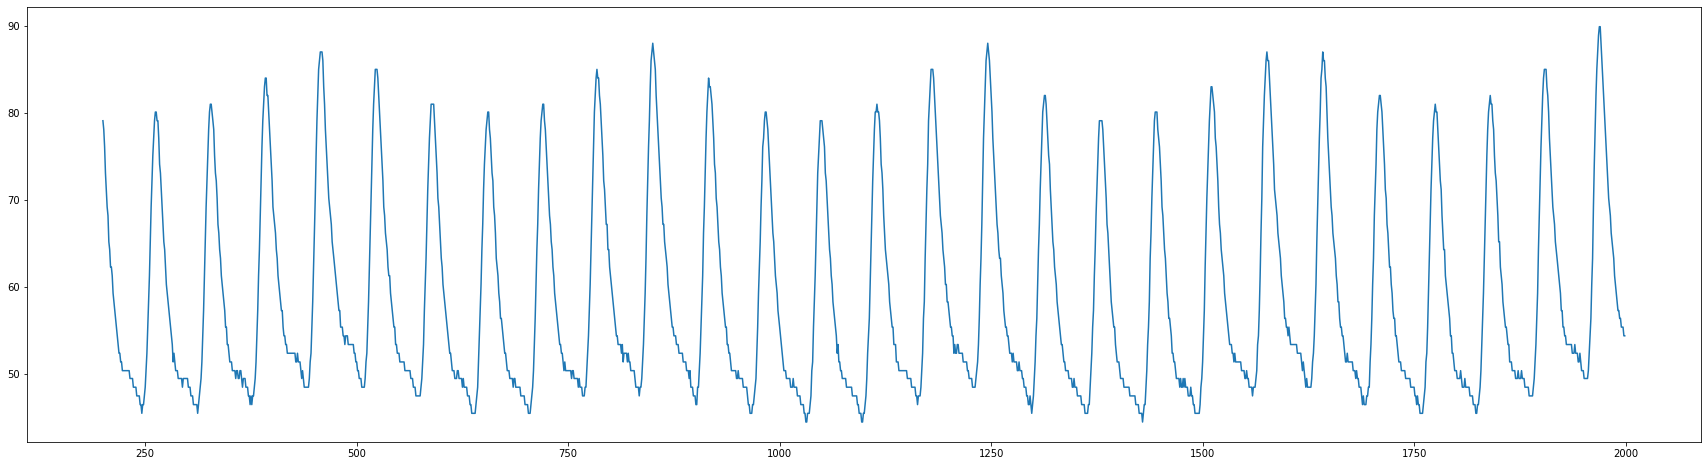

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    70.2
1996    73.1
1997    76.1
1998    79.1
1999    81.0
Name: 41061, Length: 2000, dtype: float64


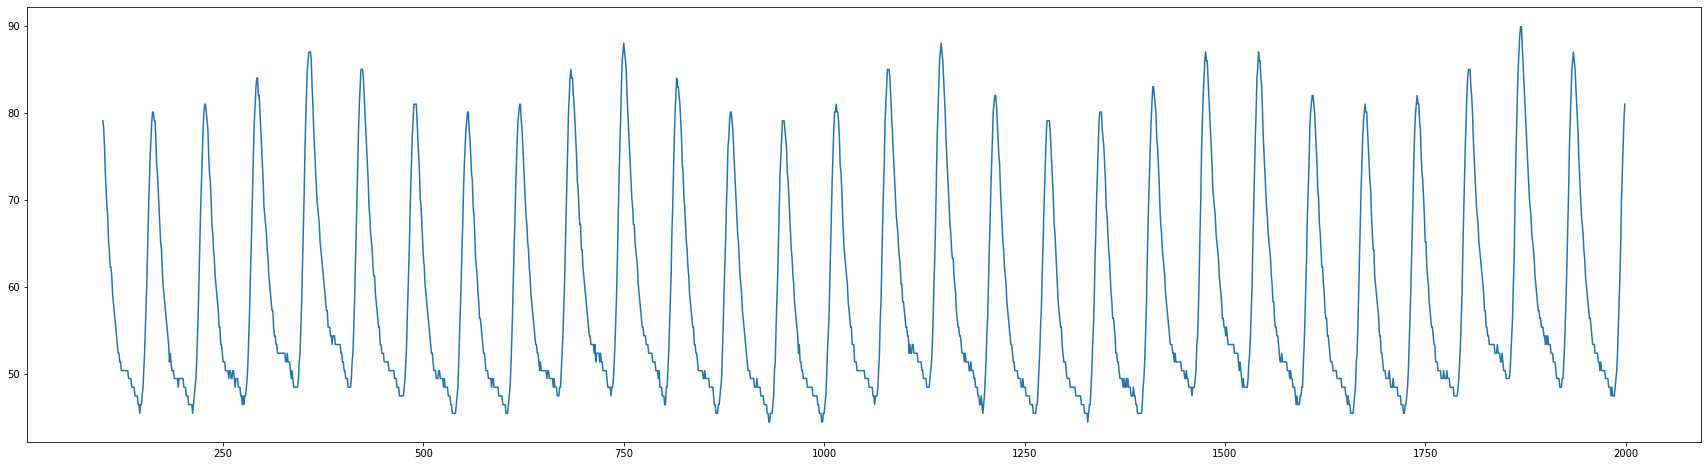

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    56.4
1996    55.4
1997    55.4
1998    54.4
1999    54.4
Name: 42450, Length: 2000, dtype: float64


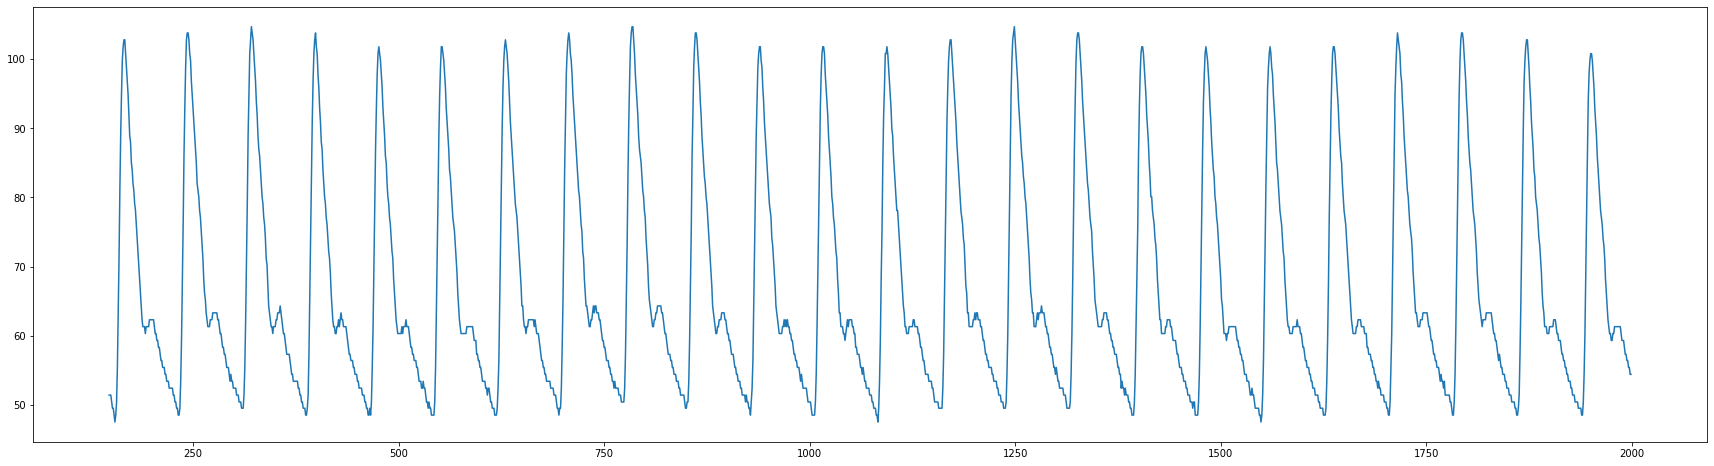

0      -17.7
1      -18.7
2      -17.7
3      -17.7
4      -17.7
        ... 
1995     NaN
1996     NaN
1997     NaN
1998     NaN
1999     NaN
Name: 44109, Length: 2000, dtype: float64


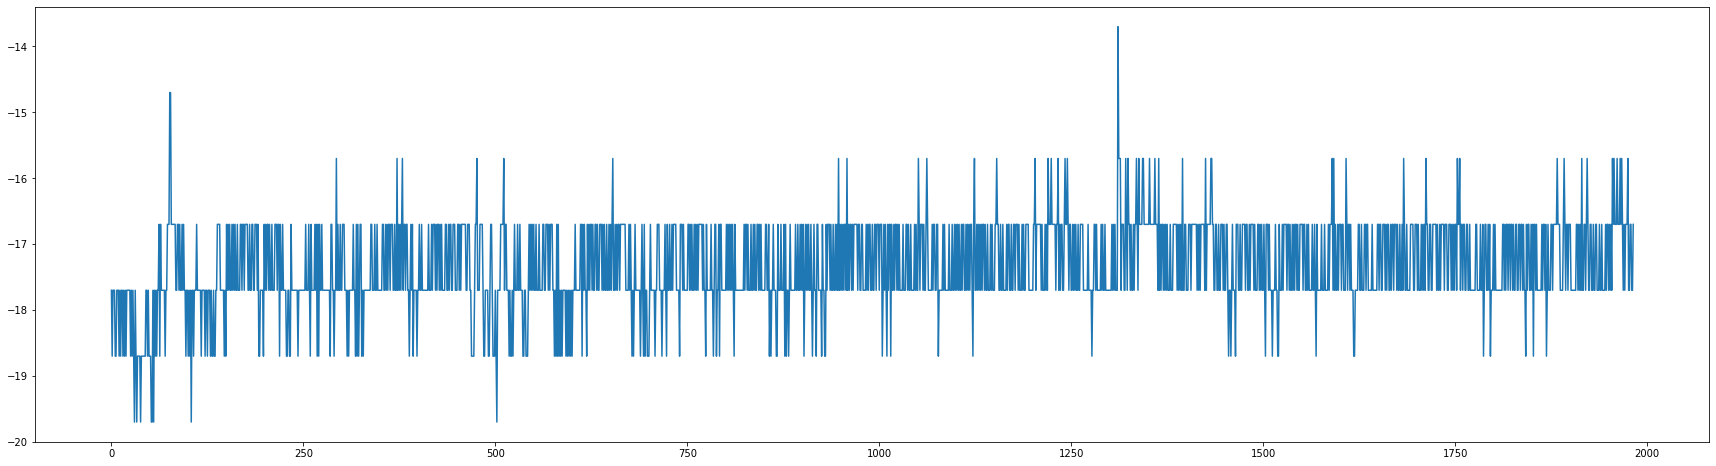

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    80.1
1996    77.1
1997    76.1
1998    74.1
1999    71.2
Name: 48469, Length: 2000, dtype: float64


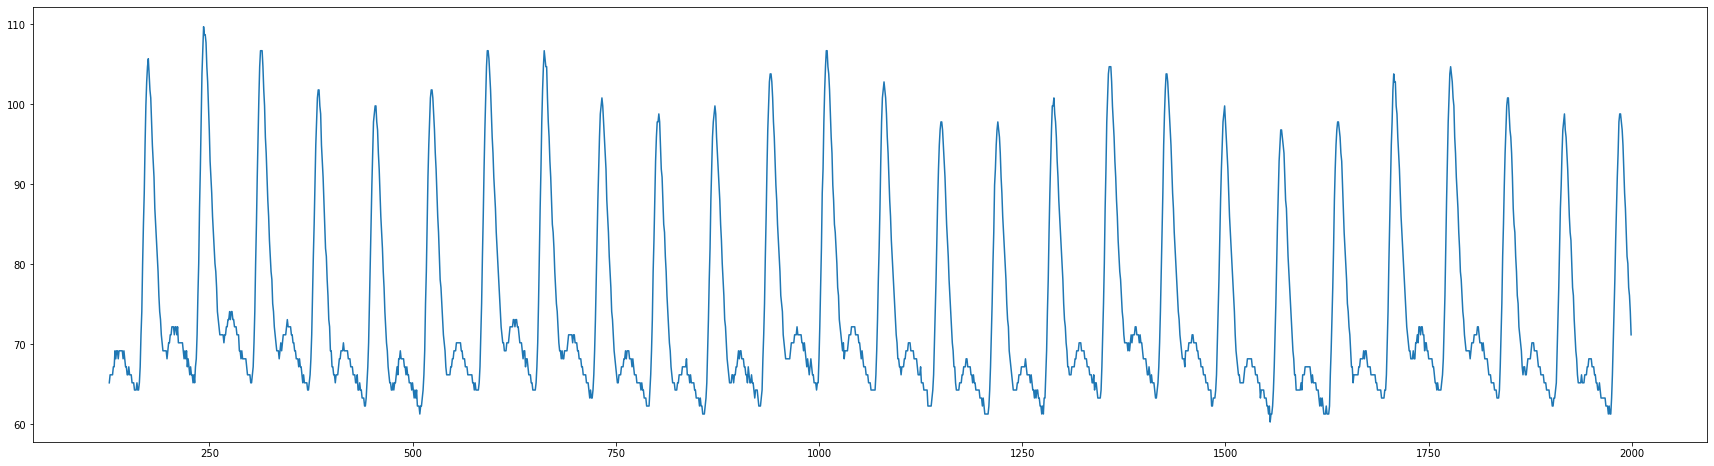

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
1995    146.2
1996    144.2
1997    140.3
1998    135.4
1999    131.4
Name: 48785, Length: 2000, dtype: float64


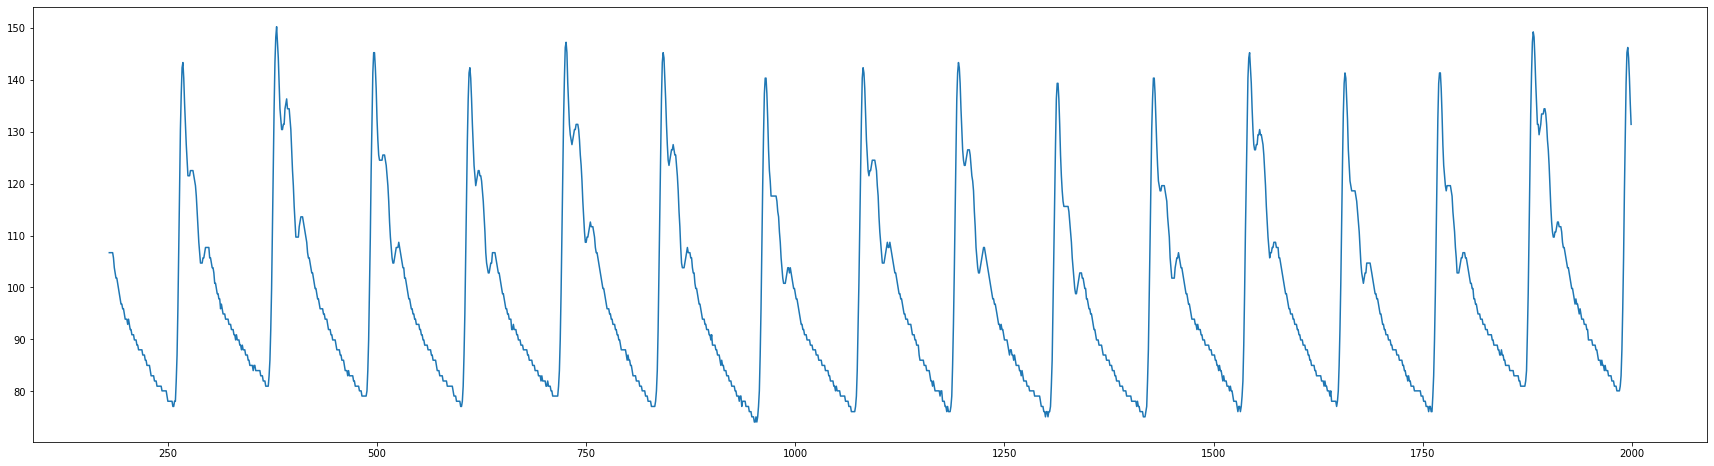

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    79.1
1996    79.1
1997    83.0
1998    84.0
1999    80.1
Name: 49428, Length: 2000, dtype: float64


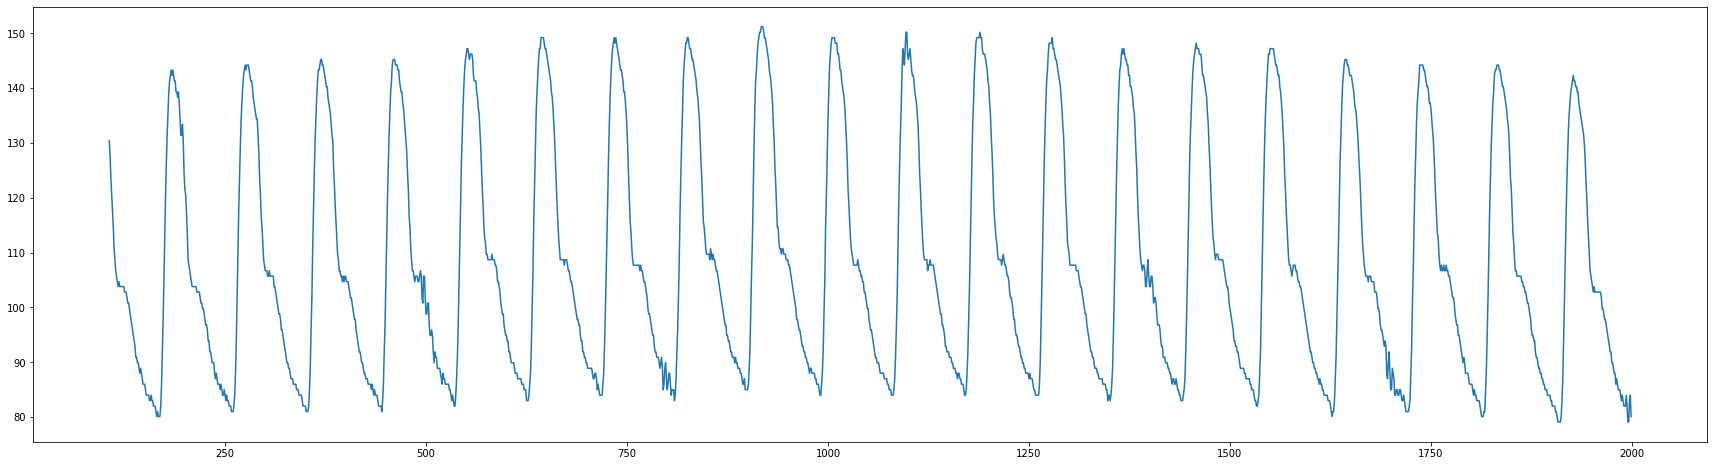

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    57.3
1996    57.3
1997    57.3
1998    57.3
1999    56.4
Name: 53791, Length: 2000, dtype: float64


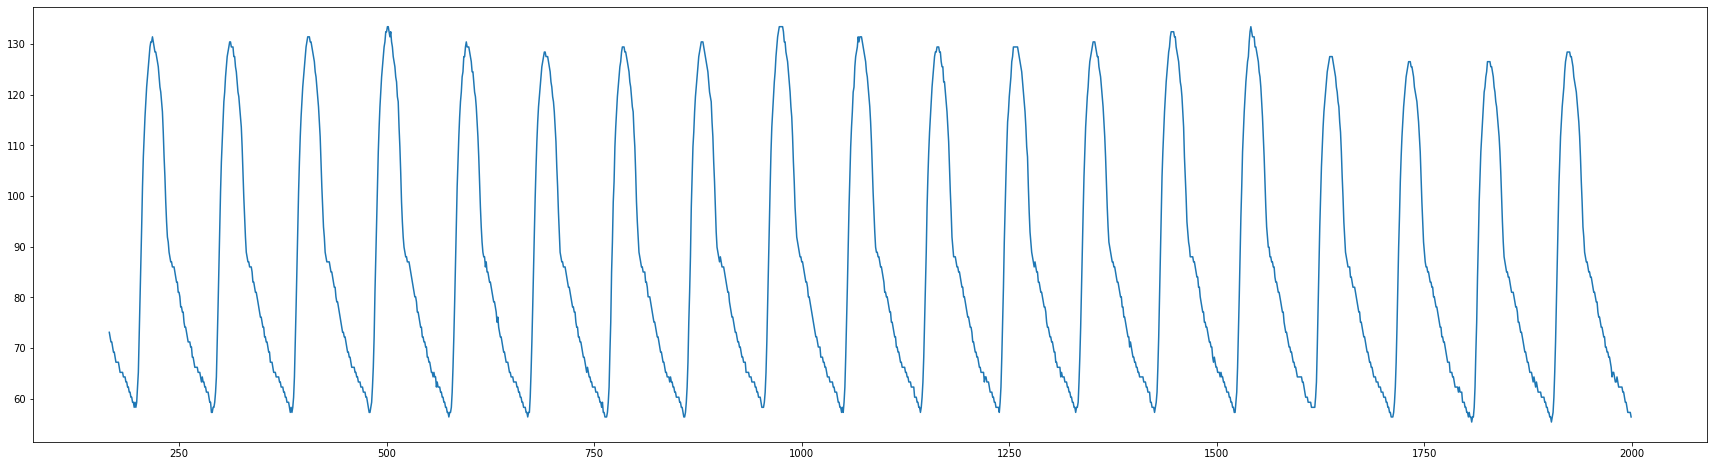

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    78.1
1996    76.1
1997    73.1
1998    71.2
1999    69.2
Name: 54028, Length: 2000, dtype: float64


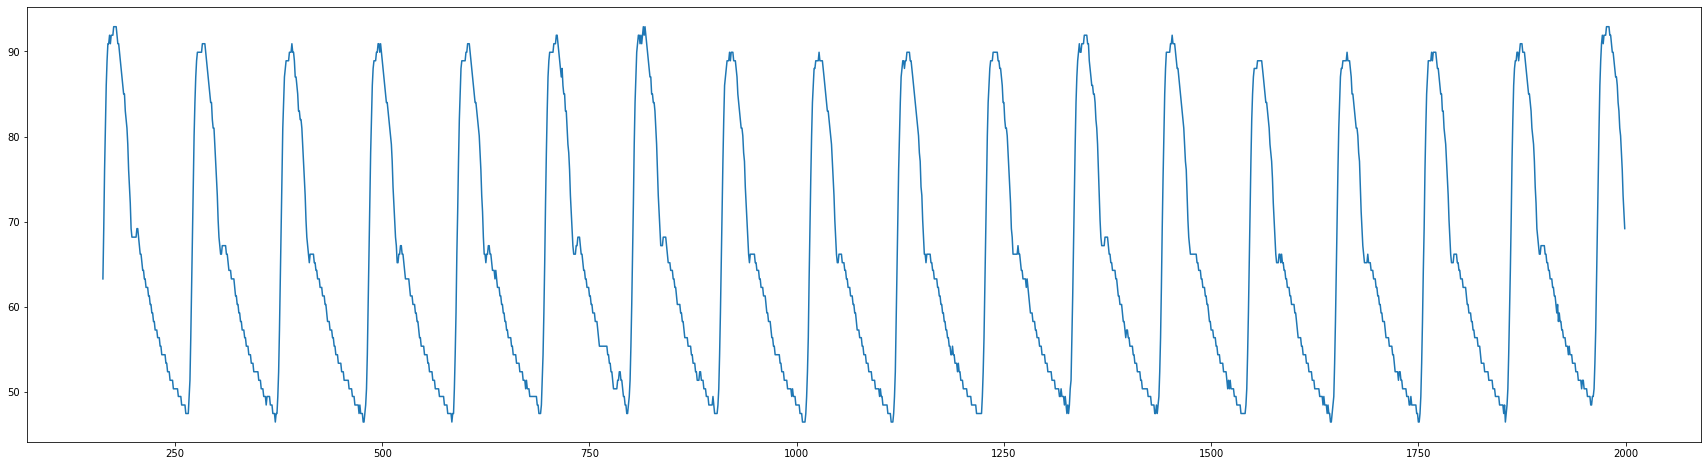

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    62.3
1996    62.3
1997    61.3
1998    60.3
1999    60.3
Name: 54251, Length: 2000, dtype: float64


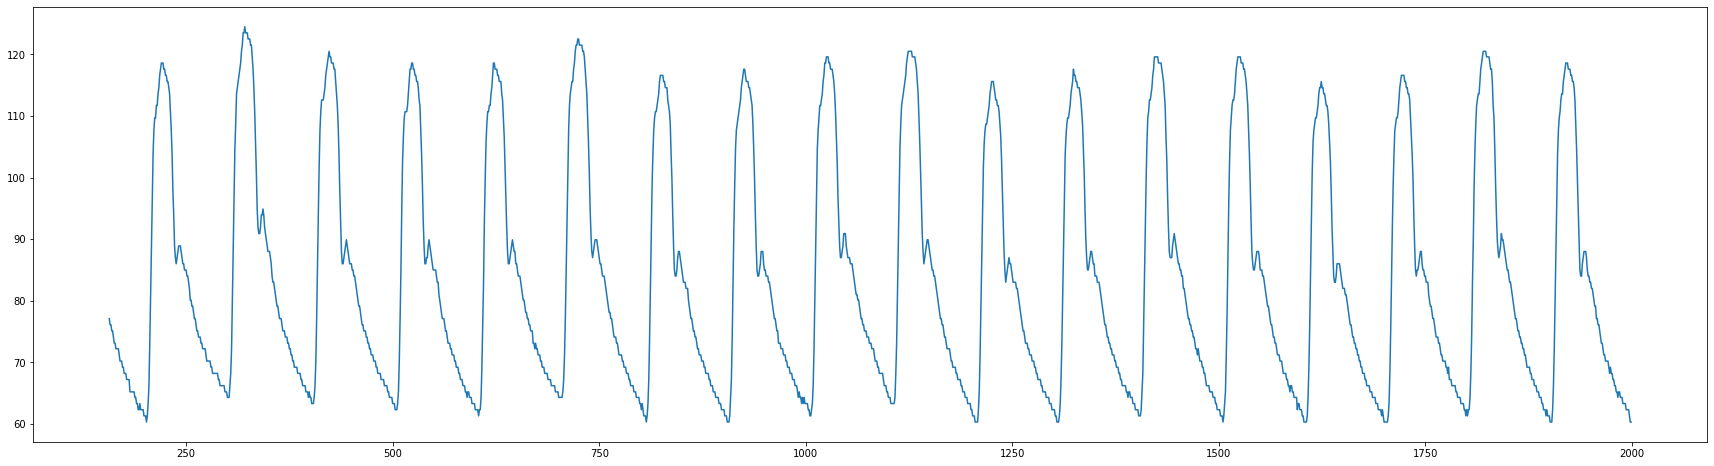

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    64.3
1996    63.3
1997    63.3
1998    62.3
1999    62.3
Name: 54604, Length: 2000, dtype: float64


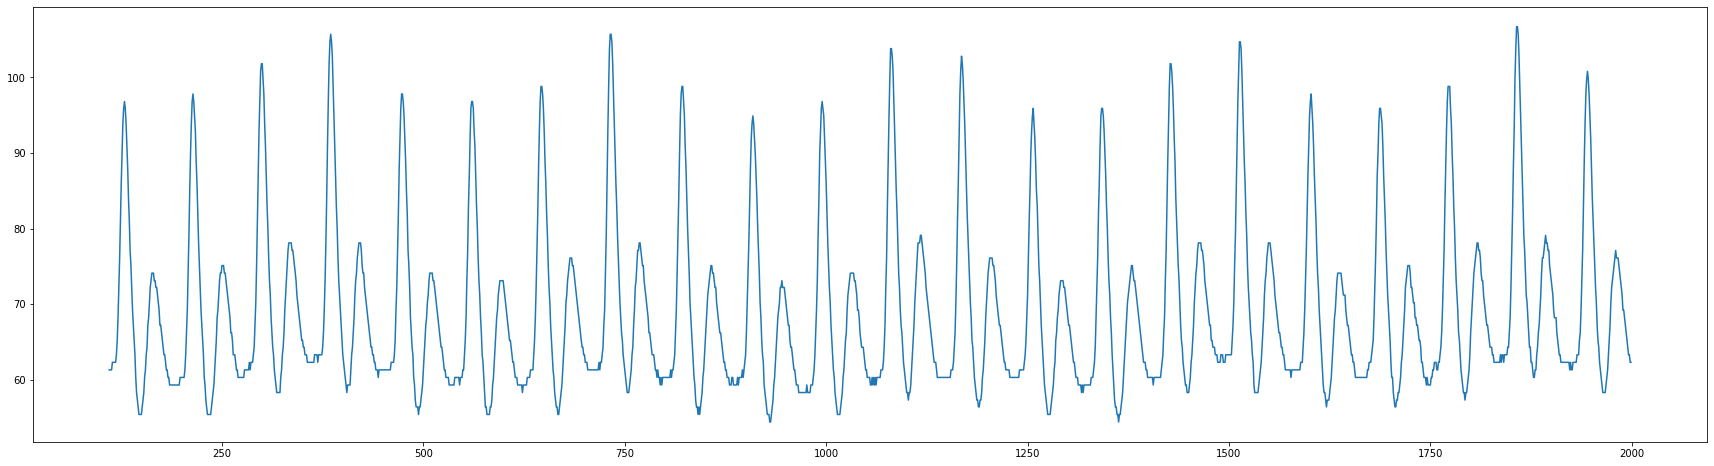

0       61.3
1       58.3
2       56.4
3       56.4
4       58.3
        ... 
1995     NaN
1996     NaN
1997     NaN
1998     NaN
1999     NaN
Name: 57071, Length: 2000, dtype: float64


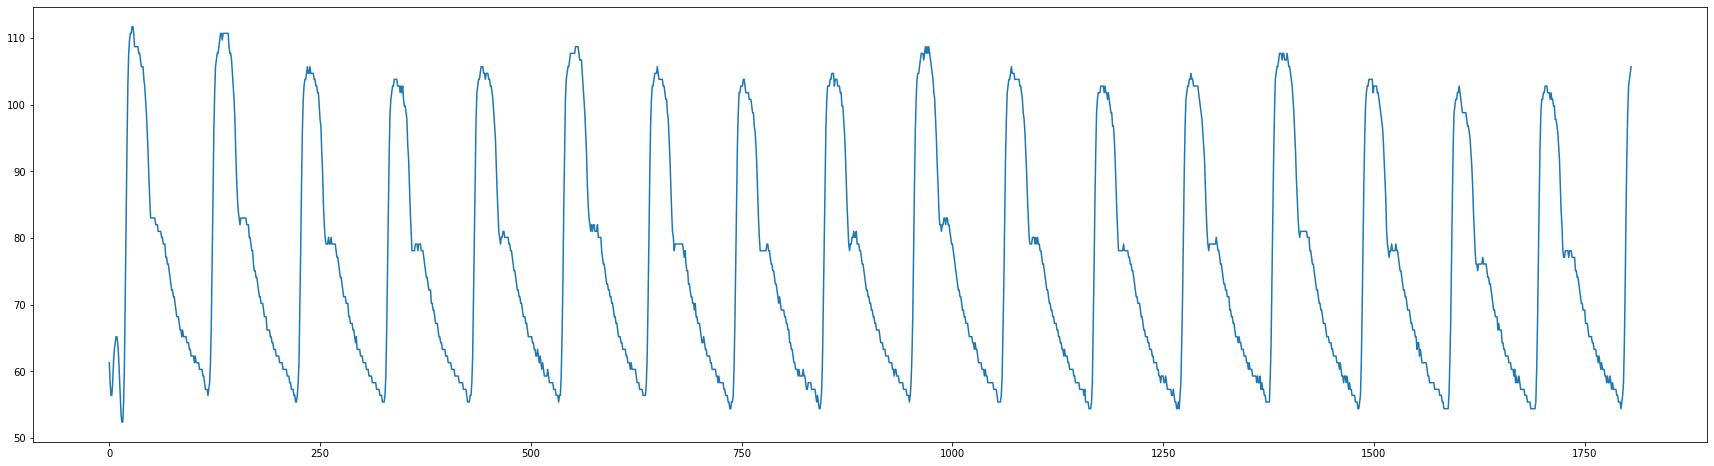

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    60.3
1996    61.3
1997    61.3
1998    61.3
1999    61.3
Name: 57848, Length: 2000, dtype: float64


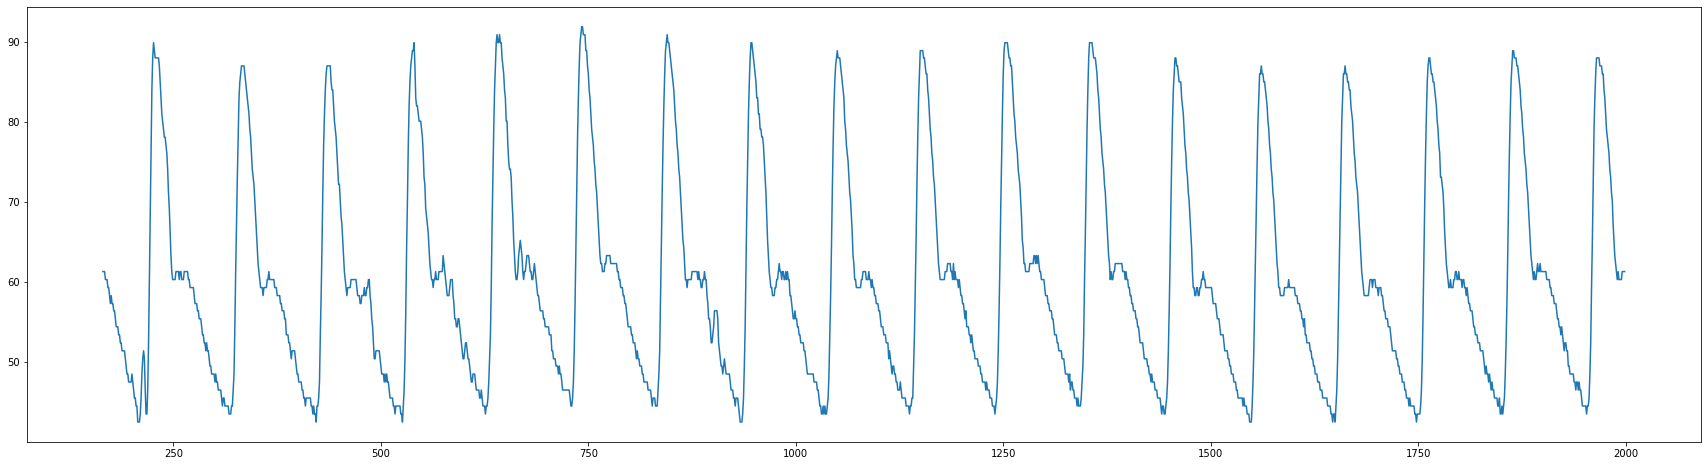

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    74.1
1996    74.1
1997    74.1
1998    74.1
1999    73.1
Name: 58373, Length: 2000, dtype: float64


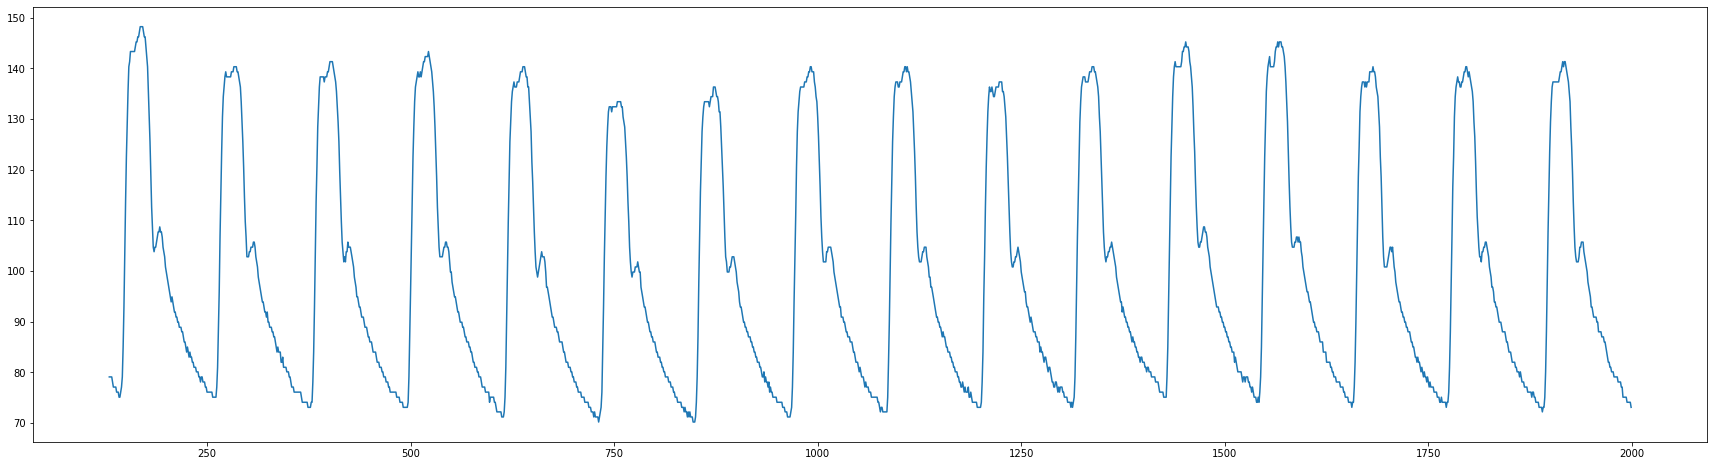

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    58.3
1996    58.3
1997    58.3
1998    57.3
1999    57.3
Name: 58522, Length: 2000, dtype: float64


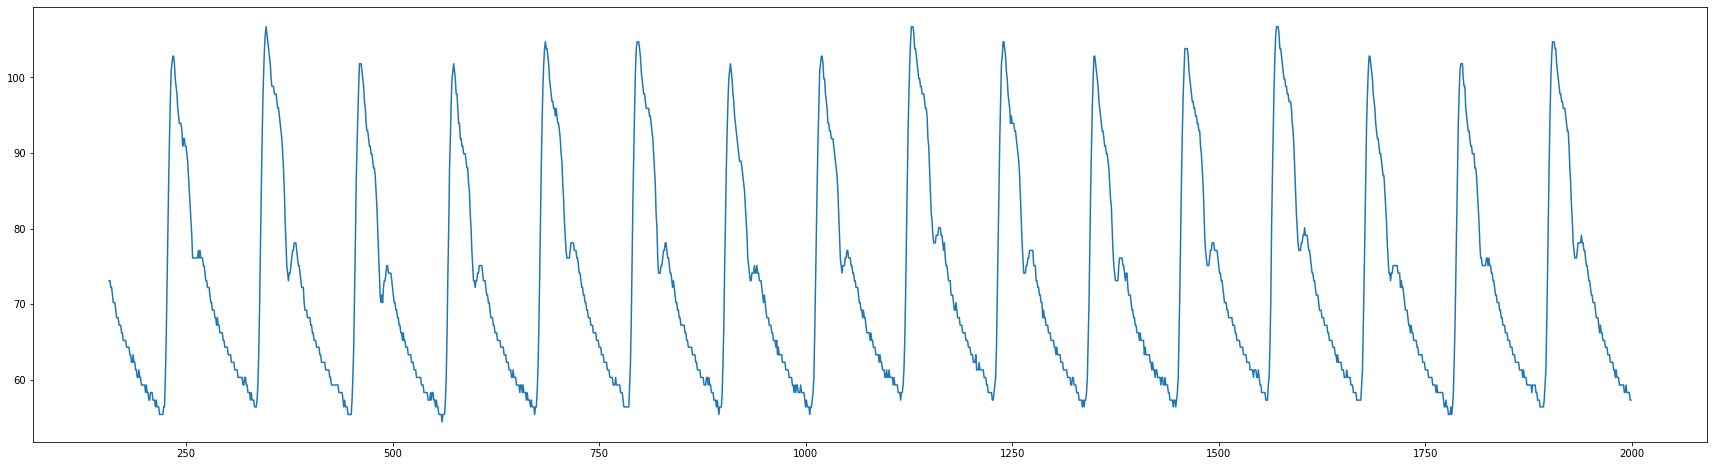

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
1995    100.8
1996     98.8
1997     98.8
1998     98.8
1999     98.8
Name: 62403, Length: 2000, dtype: float64


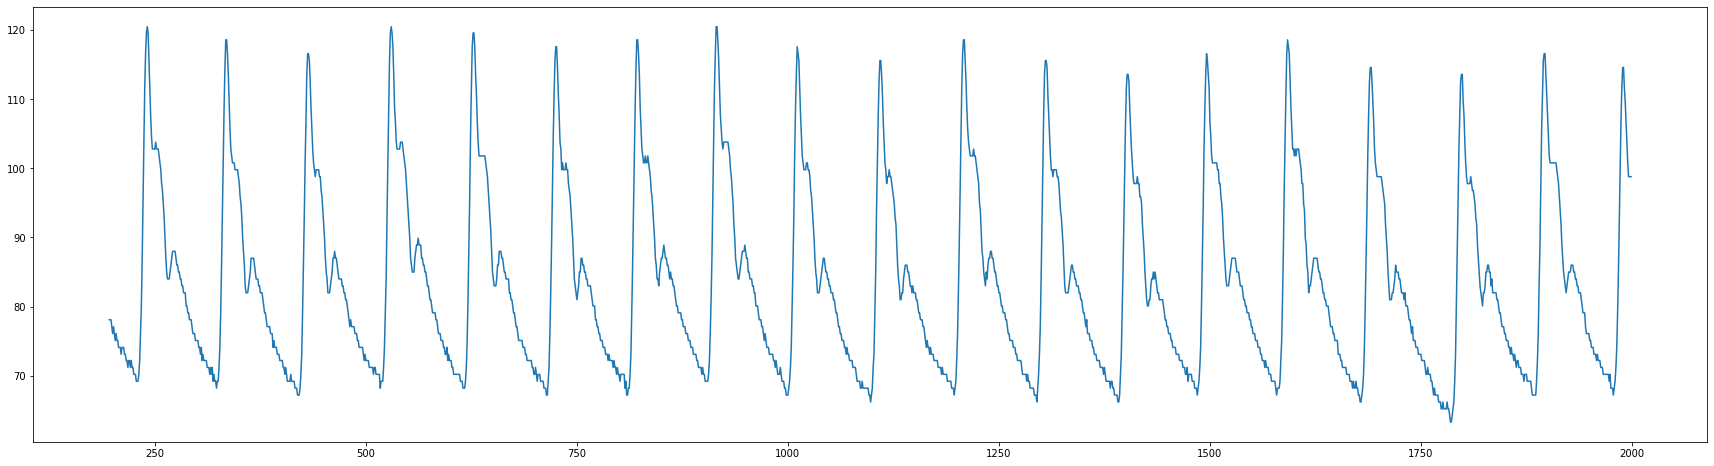

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
1995    117.6
1996    126.5
1997    132.4
1998    135.4
1999    139.3
Name: 68141, Length: 2000, dtype: float64


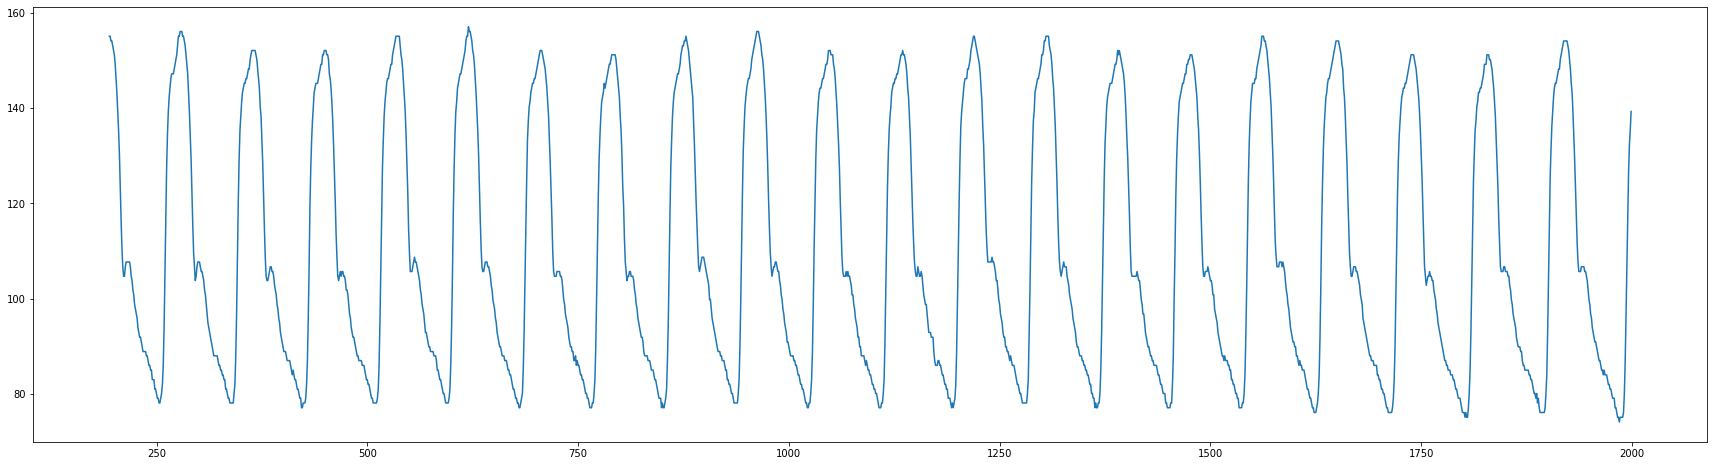

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    63.3
1996    63.3
1997    61.3
1998    62.3
1999    61.3
Name: 69691, Length: 2000, dtype: float64


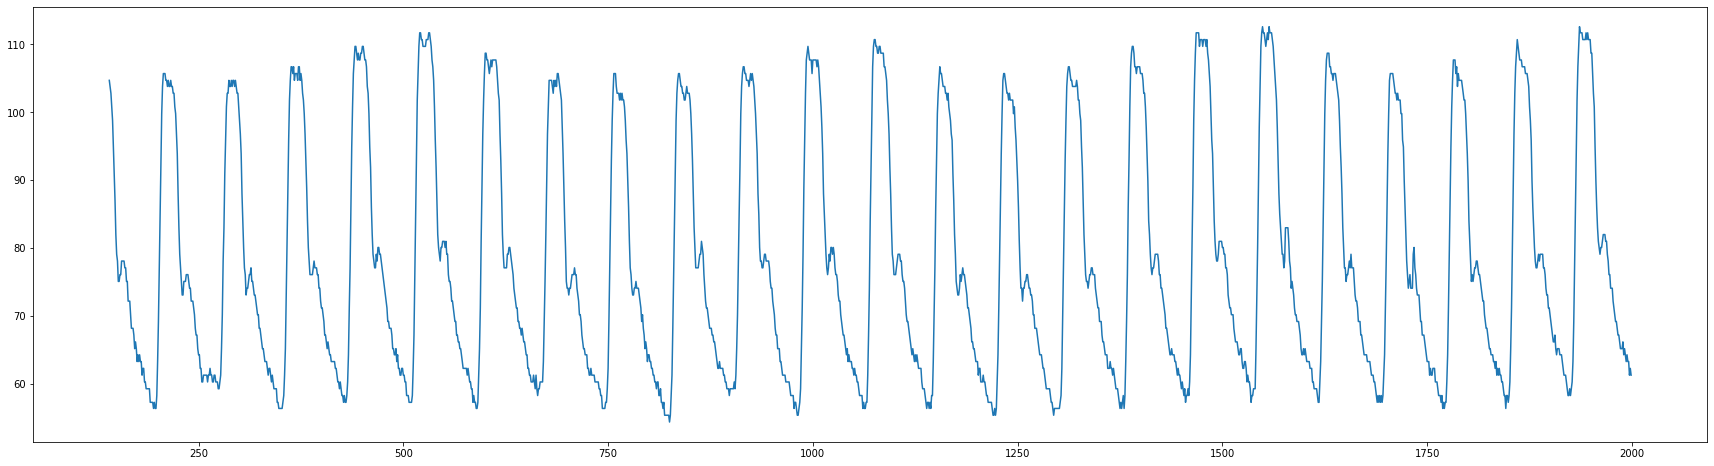

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    58.3
1996    57.3
1997    57.3
1998    57.3
1999    57.3
Name: 71286, Length: 2000, dtype: float64


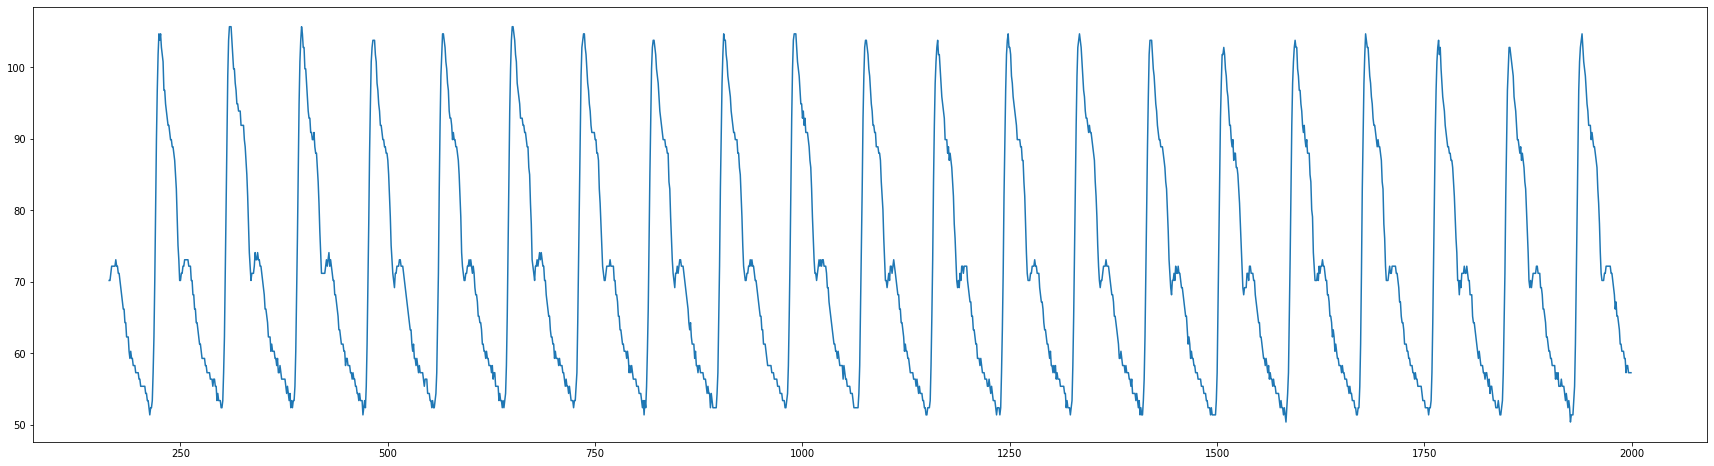

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
1995    108.7
1996    107.7
1997    106.7
1998    106.7
1999    105.7
Name: 73210, Length: 2000, dtype: float64


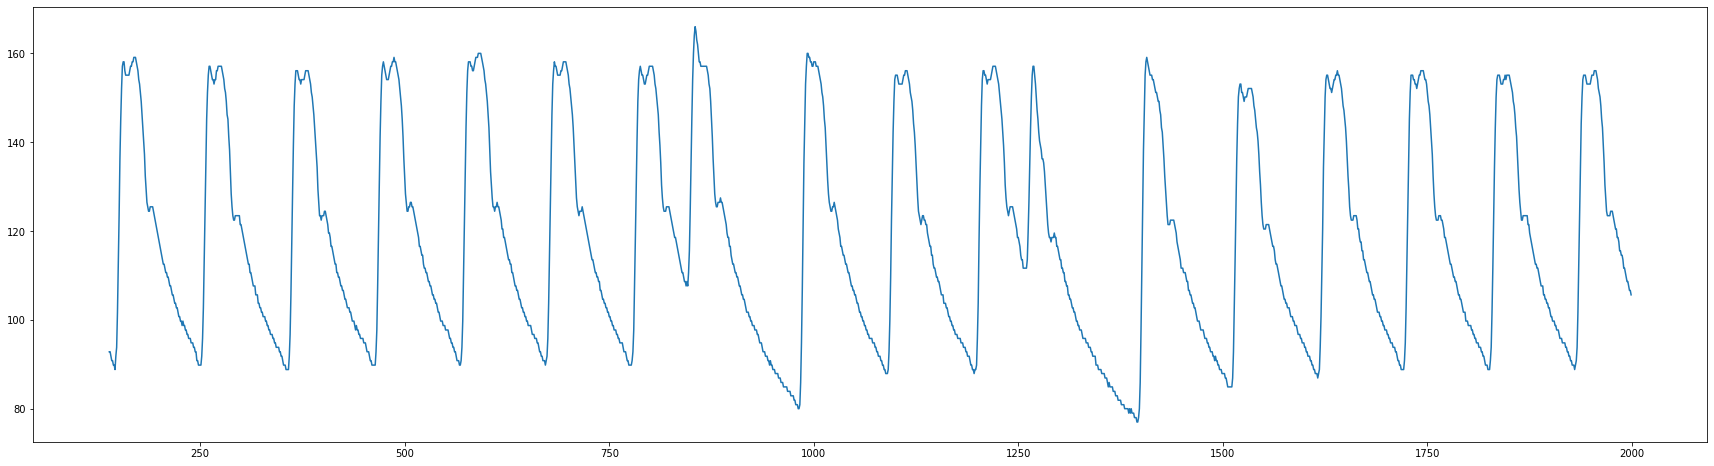

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,8))
for i in range(len(rows_with_NaN)):
  row = rows_with_NaN.iloc[i]
  print(row)
  plt.figure(figsize=(30,8))
  plt.plot(row)
  plt.show()


#transposed.plot(figsize=(30,8))




In [ ]:
rows_with_NaN.iloc[0]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    59.3
1996    58.3
1997    58.3
1998    58.3
1999    58.3
Name: 1413, Length: 2000, dtype: float64

In [ ]:
df_train["caseid"]

0          1
1          4
2          7
3         10
4         13
        ... 
3273    6381
3274    6385
3275    6386
3276    6387
3277    6388
Name: caseid, Length: 3278, dtype: int64

In [ ]:
df_train = pd.read_csv('./train_cases.csv')
len(df_train)
np.random.choice(3277, 3)


In [ ]:
x_train = []  # arterial waveform
y_train = []  # hypotension
if os.path.exists('./x_train_final.npz'):
    print('loading train...', flush=True, end='')
    x_train = np.load('./x_train_final.npz')['arr_0']
    y_train = np.load('./y_train_final.npz')['arr_0']
    print('done', flush=True)

loading train...done


In [ ]:
# test set 로딩
if os.path.exists('./x_test.npz'):
    print('loading test...', flush=True, end='')
    x_test = np.load('./x_test.npz')['arr_0']
    print('done', flush=True)

loading test...done


In [ ]:
BATCH_SIZE = 512

x_train -= 20
x_train /= 100
x_test -= 20
x_test /= 120

In [ ]:
np.savez_compressed('./x_train_real.npz', x_train)
np.savez_compressed('./y_train_real.npz', y_train)
np.savez_compressed('./x_test_real.npz', x_test)

KeyboardInterrupt: ignored

START HERE

In [ ]:
# x_train = np.load('./x_train_real.npz')['arr_0']

x_train = pd.DataFrame(x_train).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values


In [ ]:
x_test = np.load('./x_test_real.npz')['arr_0']

x_test = pd.DataFrame(x_test).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

In [ ]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization, CuDNNLSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# 임시 폴더를 생성
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# 최적의 모델을 저장
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

In [ ]:
##test data, train data -20 & /100 으로 !!

from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization, CuDNNLSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# 임시 폴더를 생성
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(CuDNNLSTM(128, input_shape=x.shape[1:]), activation='relu', return_sequences=True)
model.add(Dropout(0.2))

model.add(CuDNNLSTM(128, activation='relu')
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# 최적의 모델을 저장
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())